### Chapter 14
**CH14B AirBnB**

using the airbnb dataset

version 1.0 2023-12-28

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mizani.formatters import percent_format
from plotnine import *
import regex as re
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings

warnings.filterwarnings("ignore")

### Get Data

In [2]:
# Current script and repository folder
current_path = os.getcwd()
repository_path = current_path.split('Ch14')[0]

In [3]:
# Add utils folder to sys path 
# Note: os.path.join() creates a string with the right syntax for defining a path for your operating sytem.
sys.path.append(os.path.join(repository_path, 'utils'))

In [4]:
# Define data folder
data_path = os.path.join(repository_path, 'data')

In [5]:
# Import the prewritten helper functions
# We are only using the color palette in this notebook
from py_helper_functions import *

In [6]:
# DATA IMPORT
data = pd.read_csv(os.path.join(data_path, 'airbnb_hackney_workfile.csv'))

In [7]:
data.head()

,usd_cleaning_fee,f_property_type,f_room_type,f_room_type2,f_cancellation_policy,f_bed_type,f_neighbourhood_cleansed,usd_price_day,p_host_response_rate,n_accommodates,...,f_bathroom,ln_number_of_reviews,f_number_of_reviews,ln_days_since,ln_days_since2,ln_days_since3,n_days_since2,n_days_since3,ln_review_scores_rating,f_minimum_nights
0,NaN,Apartment,Private room,Private,flexible,Real Bed,Hackney,65,100.0,2,...,1.0,1.386294,1.0,7.290975,53.158313,387.575921,2152089.0,3.157115e+09,4.521789,1.0
1,NaN,House,Private room,Private,moderate,Real Bed,Hackney,30,NaN,2,...,2.0,1.098612,1.0,6.350886,40.333749,256.155033,328329.0,1.881325e+08,4.499810,1.0
2,NaN,Apartment,Private room,Private,moderate,Couch,Hackney,150,100.0,7,...,1.0,3.496508,1.0,7.461066,55.667499,415.338854,3024121.0,5.258946e+09,4.574711,2.0
3,25.0,House,Private room,Private,moderate,Real Bed,Hackney,29,100.0,2,...,1.0,3.970292,2.0,6.385194,40.770708,260.328893,351649.0,2.085279e+08,4.543295,1.0
4,20.0,Apartment,Entire home/apt,Entire/Apt,moderate,Real Bed,Hackney,65,100.0,2,...,1.0,4.025352,2.0,7.288244,53.118506,387.140657,2140369.0,3.131360e+09,4.477337,2.0


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4496 entries, 0 to 4495
Data columns (total 90 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   usd_cleaning_fee           2769 non-null   float64
 1   f_property_type            4496 non-null   object 
 2   f_room_type                4496 non-null   object 
 3   f_room_type2               4496 non-null   object 
 4   f_cancellation_policy      4496 non-null   object 
 5   f_bed_type                 4496 non-null   object 
 6   f_neighbourhood_cleansed   4496 non-null   object 
 7   usd_price_day              4496 non-null   int64  
 8   p_host_response_rate       2970 non-null   float64
 9   n_accommodates             4496 non-null   int64  
 10  n_bathrooms                4487 non-null   float64
 11  n_review_scores_rating     3073 non-null   float64
 12  n_number_of_reviews        4496 non-null   int64  
 13  n_guests_included          4496 non-null   int64

### Feature Engineering

In [9]:
# where do we have missing variables now?
to_filter=data.isna().sum()
to_filter[to_filter>0].index

Index(['usd_cleaning_fee', 'p_host_response_rate', 'n_bathrooms',
       'n_review_scores_rating', 'n_reviews_per_month', 'n_beds',
       'n_days_since', 'd_reviews_per_month', 'ln_beds', 'f_bathroom',
       'f_number_of_reviews', 'ln_days_since', 'ln_days_since2',
       'ln_days_since3', 'n_days_since2', 'n_days_since3',
       'ln_review_scores_rating', 'f_minimum_nights'],
      dtype='object')

#### Missing values

In [10]:
# 1. drop if no target (already did)
data.dropna(subset=['price'], inplace = True)

In [12]:
# 2. imput when few, not that important
data['n_bathrooms']=data['n_bathrooms'].fillna(np.nanmedian(data['n_bathrooms']))
data['n_beds']=data['n_beds'].fillna(data['n_accommodates'])
data['f_bathroom']=data['f_bathroom'].fillna(1)
data['f_minimum_nights']=data['f_minimum_nights'].fillna(1)
data['f_number_of_reviews']=data['f_number_of_reviews'].fillna(1)
data['ln_beds']=data['ln_beds'].fillna(0)

In [13]:
data['n_bathrooms'].describe()

count    4496.000000
mean        1.225534
std         0.479690
min         0.000000
25%         1.000000
50%         1.000000
75%         1.500000
max         8.000000
Name: n_bathrooms, dtype: float64

In [14]:
# 3. drop columns when many missing not important
data=data.drop(["usd_cleaning_fee", "p_host_response_rate"],axis=1)

In [15]:
# where do we have missing variables now?
to_filter=data.isna().sum()
to_filter[to_filter>0].index

Index(['n_review_scores_rating', 'n_reviews_per_month', 'n_days_since',
       'd_reviews_per_month', 'ln_days_since', 'ln_days_since2',
       'ln_days_since3', 'n_days_since2', 'n_days_since3',
       'ln_review_scores_rating'],
      dtype='object')

In [16]:
for var in ["flag_days_since","flag_review_scores_rating","flag_reviews_per_month"]:
    data[var]=[int(x) for x in data[var.replace('flag','n')].isna()]

In [17]:
data['flag_days_since'].count()

4496

In [18]:
# 4. Replace missing variables re reviews with zero, when no review + add flags
data['n_days_since']=data['n_days_since'].fillna(np.nanmedian(data['n_days_since']))
data['n_review_scores_rating']=data['n_review_scores_rating'].fillna(np.nanmedian(data['n_review_scores_rating']))
data['n_reviews_per_month']=data['n_reviews_per_month'].fillna(np.nanmedian(data['n_reviews_per_month']))

In [19]:
data.flag_days_since.value_counts()

0    3147
1    1349
Name: flag_days_since, dtype: int64

In [20]:
# Look at data
data.price.describe()

count    4496.000000
mean       80.556940
std        58.915794
min        10.000000
25%        40.000000
50%        65.000000
75%       100.000000
max       850.000000
Name: price, dtype: float64

In [21]:
# where do we have missing variables now?
to_filter=data.isna().sum()
to_filter[to_filter>0]

d_reviews_per_month        1349
ln_days_since              1350
ln_days_since2             1350
ln_days_since3             1350
n_days_since2              1349
n_days_since3              1349
ln_review_scores_rating    1423
dtype: int64

In [22]:
###################################
# Business logic- define our prediction problem
###################################
# Decision
# Size, we need a normal apartment, 1-7persons
data=data.loc[data.n_accommodates < 8]

### EDA

In [25]:
#How is the average price changing in my district by `property_type`, `room_type` and the `bed_type`?
data.groupby(["f_property_type", "f_room_type"]).agg(mean_price=("price", np.mean))

mean_price
f_property_type f_room_type                
Apartment       Entire home/apt  106.364341
                Private room      48.034439
                Shared room       50.708333
House           Entire home/apt  134.794118
                Private room      42.931487
                Shared room       38.666667

In [26]:
data.groupby(["f_bed_type"]).agg(mean_price=("price", np.mean))

,mean_price
f_bed_type,
Couch,49.091954
Real Bed,77.838365


In [27]:
data.price.describe()

count    4393.000000
mean       77.269064
std        53.265471
min        10.000000
25%        40.000000
50%        65.000000
75%        99.000000
max       850.000000
Name: price, dtype: float64

In [28]:
# How are extreme prices distributed?
data.price.quantile([0.75, 0.8, 0.9, 0.95, 0.99, 0.995])

0.750     99.00
0.800    103.00
0.900    140.00
0.950    180.00
0.990    254.12
0.995    300.00
Name: price, dtype: float64

In [29]:
# We pick USD 400, above which all observations are excluded in the charts below.
datau=data[data.price<400]

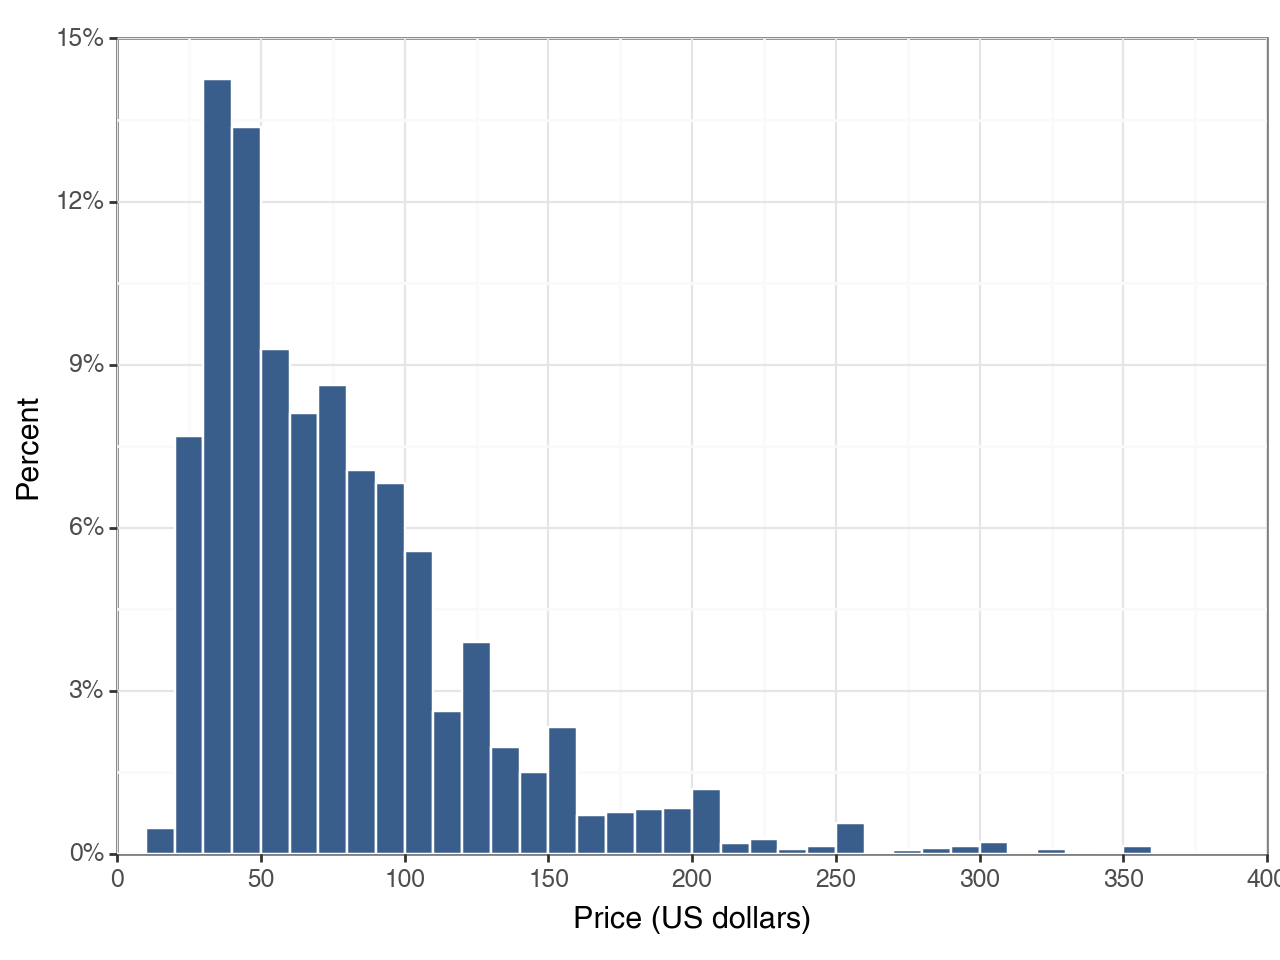

<Figure Size: (640 x 480)>

In [30]:
# Distribution of price by type below 400# Histograms# price
(
    ggplot(datau, aes(x="price"))
    + geom_histogram(
        aes(y="stat(count)/sum(stat(count))"),
        binwidth=10,
        fill=color[0],
        color="white",
        alpha=0.8,
        boundary=0,
        closed="left",
    )
    + labs(x="Price (US dollars)", y="Percent")
    + scale_y_continuous(
        expand=(0.00, 0.00),
        limits=(0, 0.15),
        breaks=seq(0, 0.16, by=0.03),
        labels=percent_format(),
    )
    + scale_x_continuous(expand=(0.00, 0.00), limits=(0, 400), breaks=seq(0, 401, 50))
    + theme_bw()
)

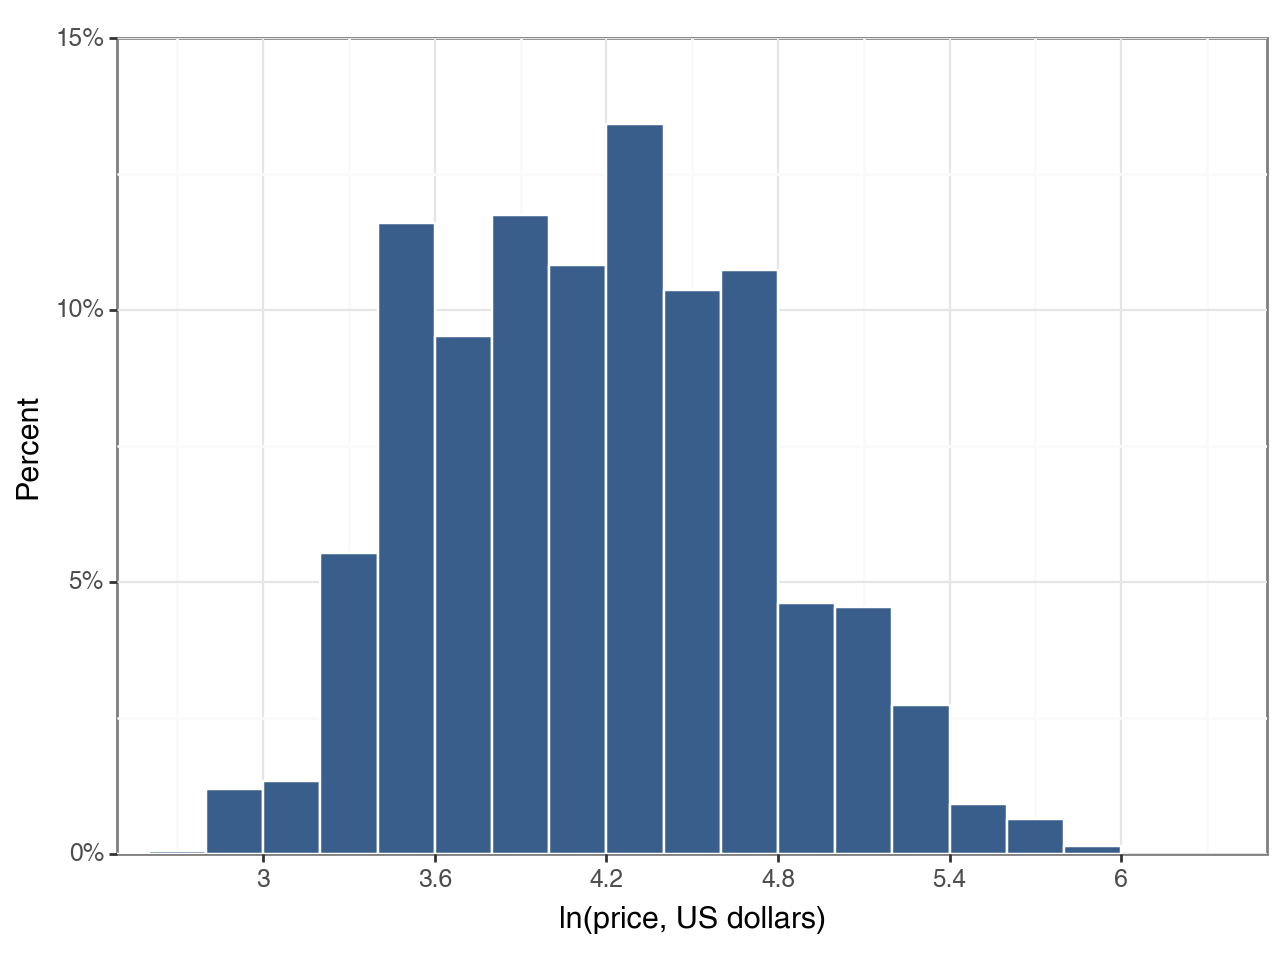

<Figure Size: (640 x 480)>

In [31]:
(
    ggplot(datau, aes(x="ln_price"))
    + geom_histogram(
        aes(y="stat(count)/sum(stat(count))"),
        binwidth=0.2,
        fill=color[0],
        color="white",
        alpha=0.8,
        boundary=0,
        closed="left",
    )
    + coord_cartesian(xlim=(2.5, 6.5))
    + scale_y_continuous(
        expand=(0.00, 0.00),
        limits=(0, 0.15),
        breaks=seq(0, 0.16, by=0.05),
        labels=percent_format(),
    )
    + scale_x_continuous(expand=(0.00, 0.01), breaks=seq(2.4, 6.7, 0.6))
    + labs(x="ln(price, US dollars)", y="Percent")
    + theme_bw()
)

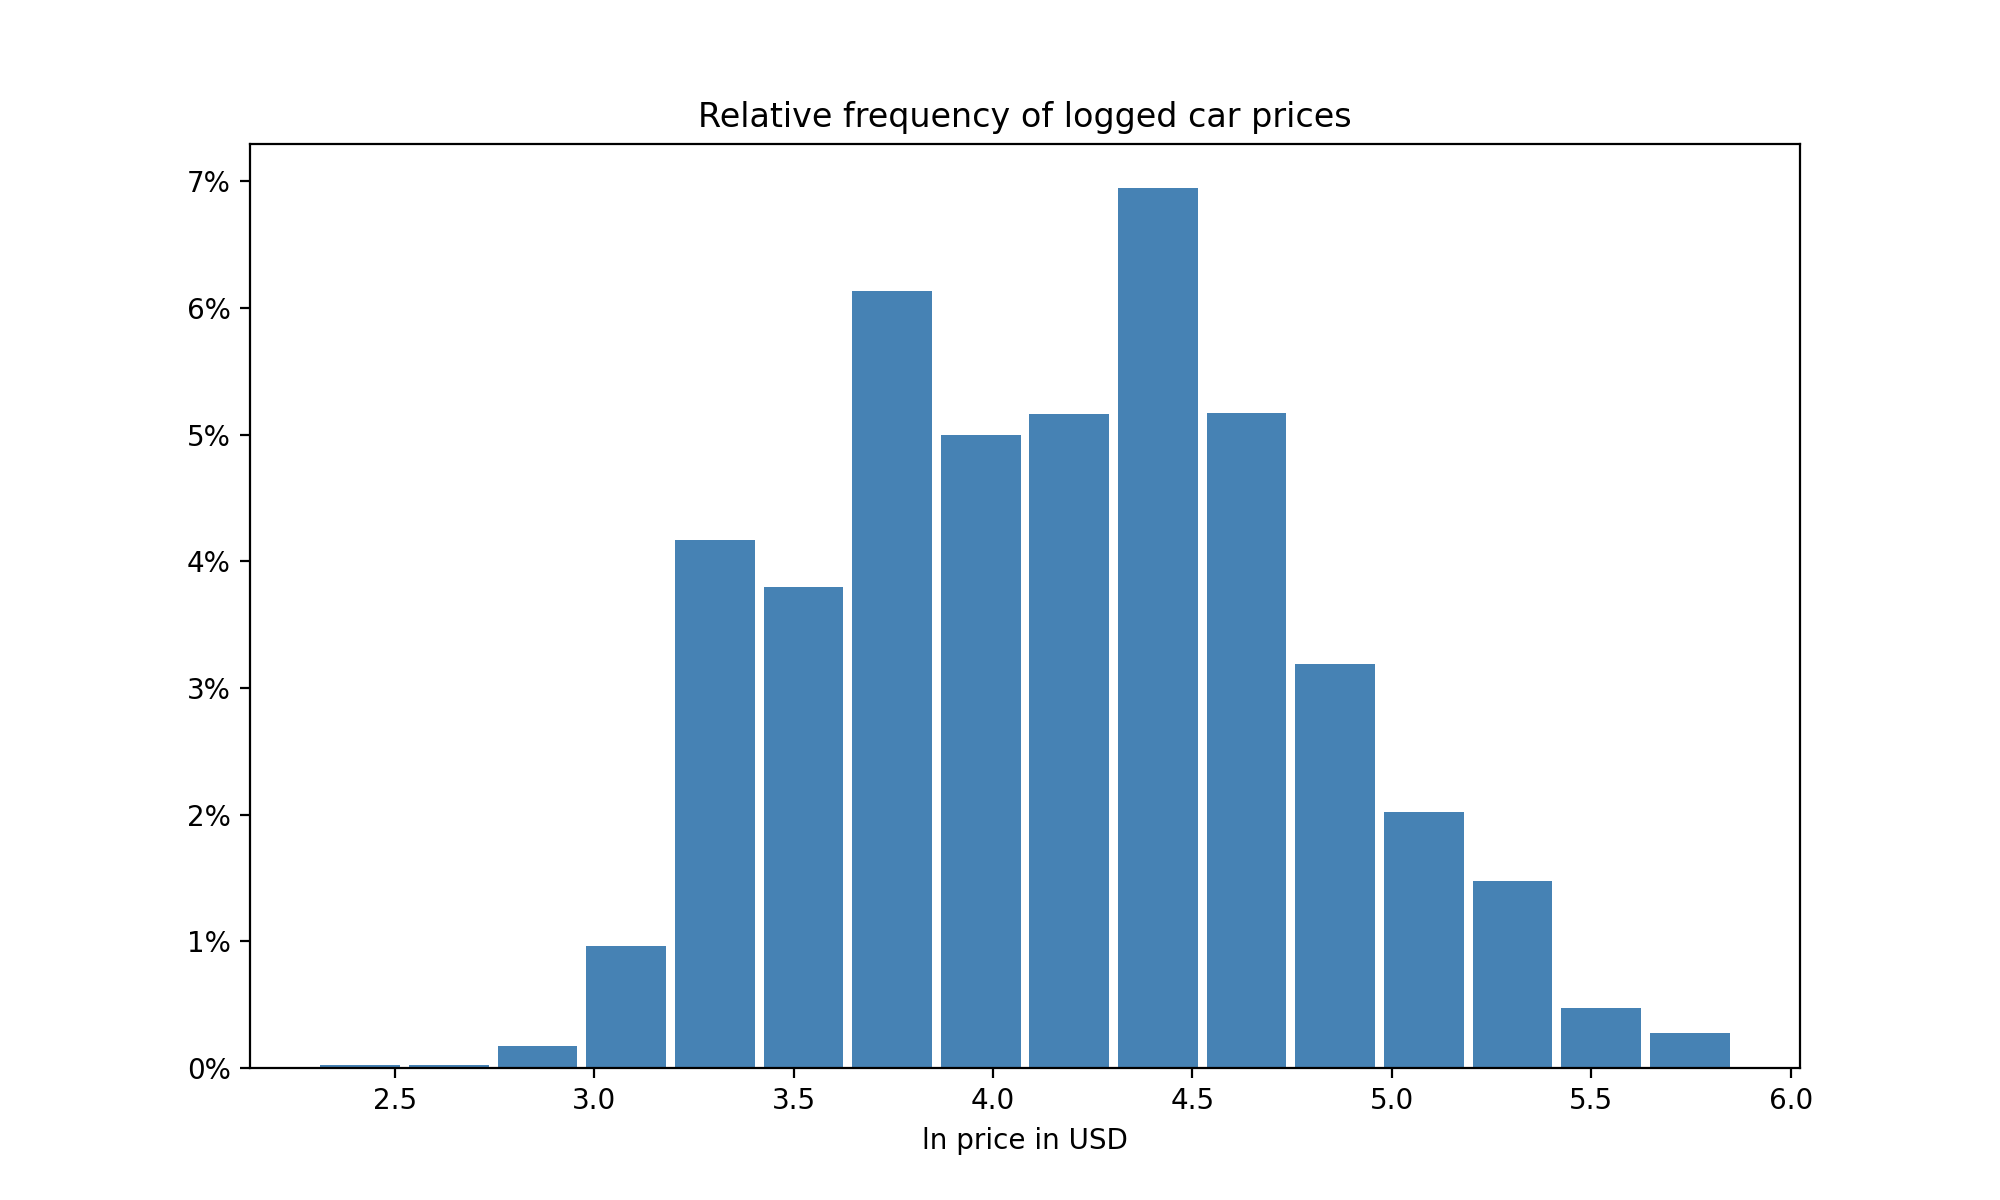

In [32]:
# relative frequencies with matplotlib
# the distribution is different as matplotlib splits the observations into different buckets than ggplot
from matplotlib.ticker import PercentFormatter
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.hist(datau.ln_price, bins = 16, density = True, rwidth = 0.9, color = 'steelblue')
# ax.set_xticks(range(0, data.price.max(), 2000))
ax.set_xlabel('ln price in USD')
ax.yaxis.set_major_formatter(PercentFormatter(xmax=10, decimals = 0))
ax.set_title('Relative frequency of logged car prices')
plt.show()

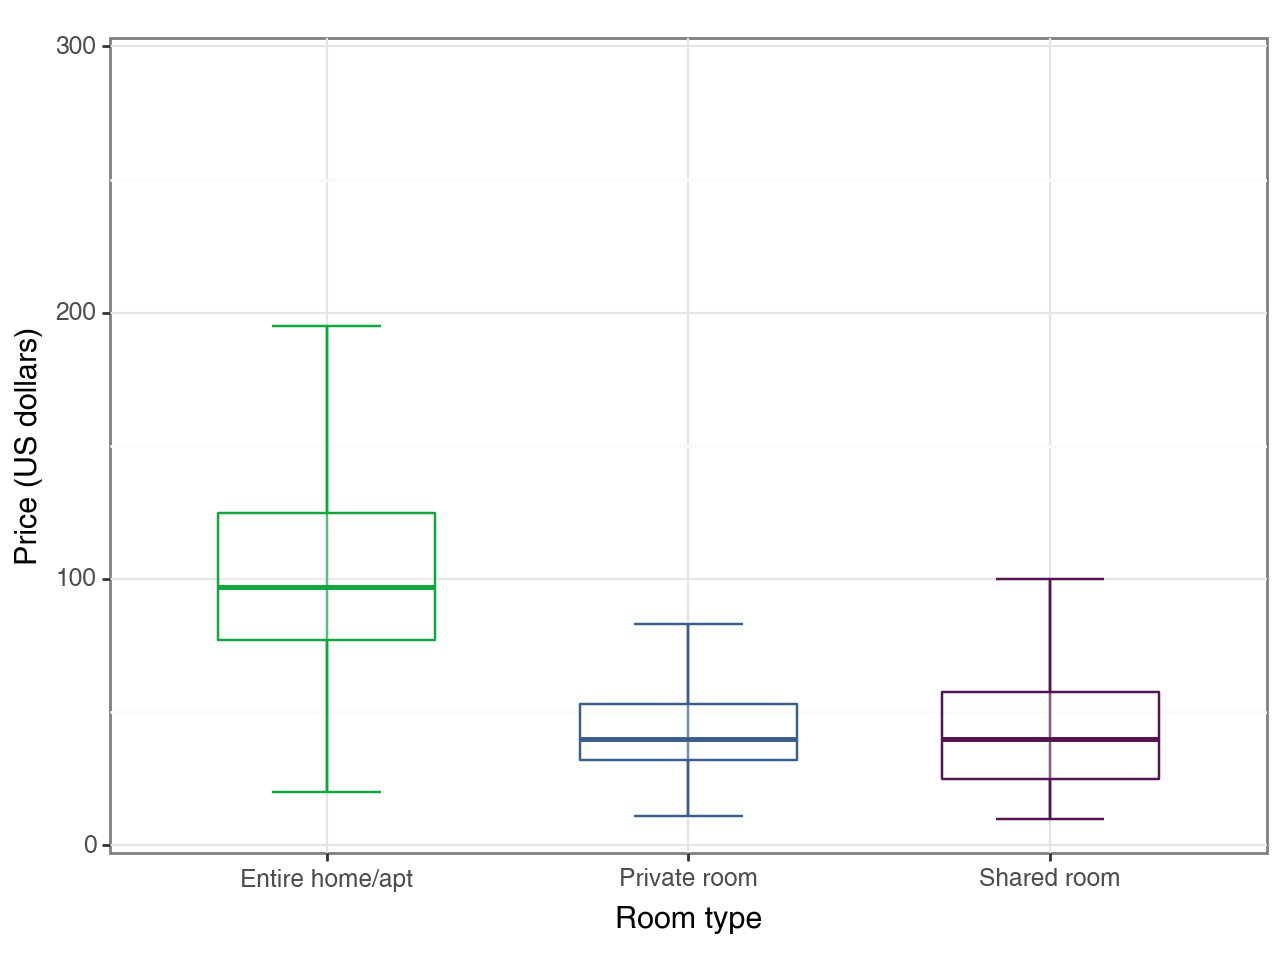

<Figure Size: (640 x 480)>

In [33]:
## Boxplot of price by room type
(
    ggplot(datau, aes(x="f_room_type", y="price"))
    + stat_boxplot(
        aes(group="f_room_type"),
        geom="errorbar",
        width=0.3,
        color=(color[1], color[0], color[2]),
        size=0.5,
        na_rm=True,
    )
    + geom_boxplot(
        aes(group="f_room_type"),
        color=(color[1], color[0], color[2]),
        # fill=(color[1], color[0], color[2]),
        size=0.5,
        width=0.6,
        alpha=0.3,
        na_rm=True,
        outlier_shape="",
    )
    + scale_y_continuous(expand=(0.01, 0.01), limits=(0, 300), breaks=seq(0, 301, 100))
    + labs(x="Room type", y="Price (US dollars)")
    + theme_bw()
)

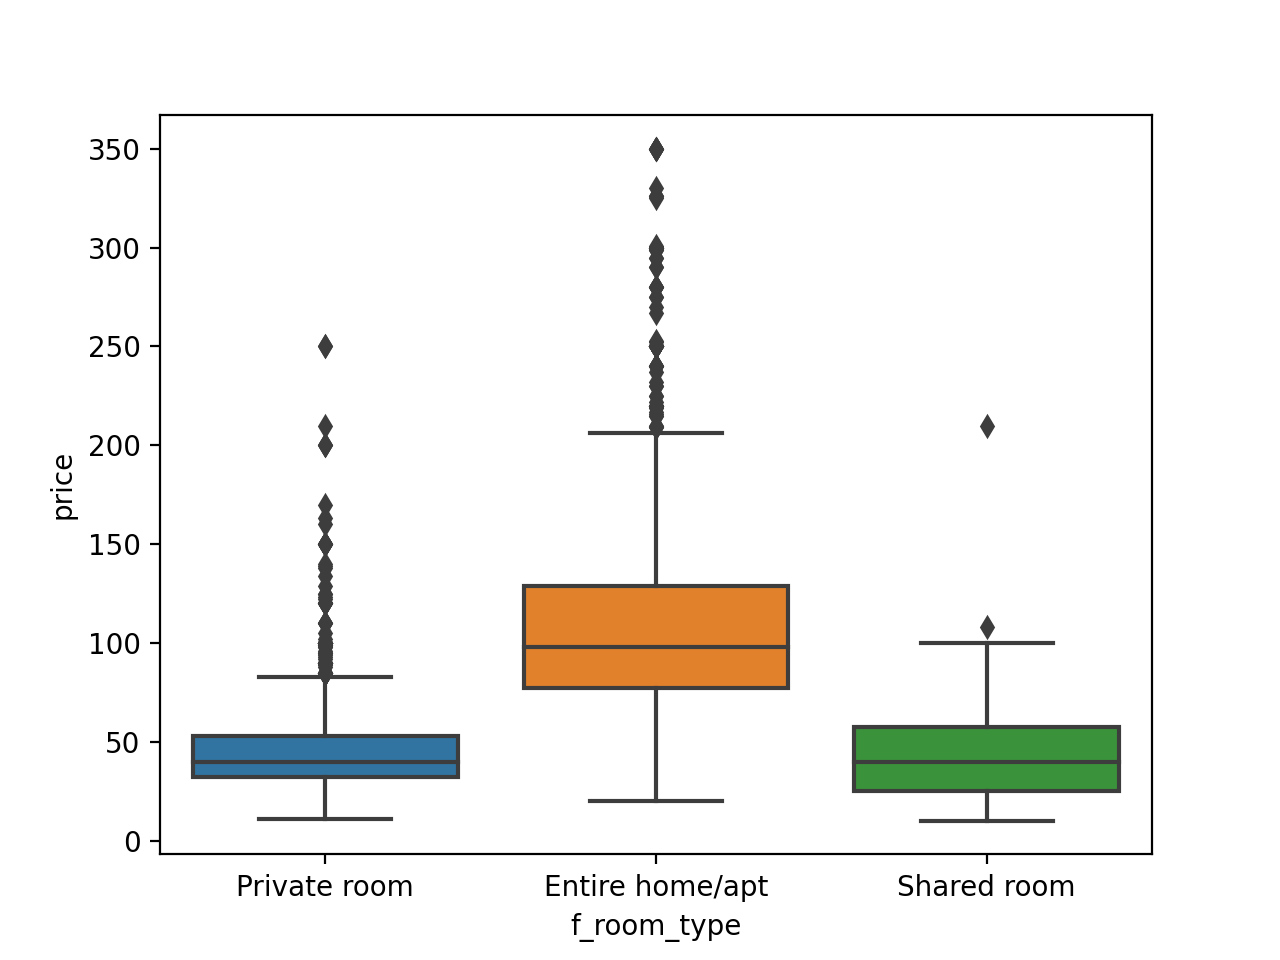

In [34]:
sns.boxplot(data = datau, x = 'f_room_type', y = 'price', orient = 'v')
plt.show()

In [35]:
datau.f_room_type.value_counts()

Private room       2252
Entire home/apt    2106
Shared room          27
Name: f_room_type, dtype: int64

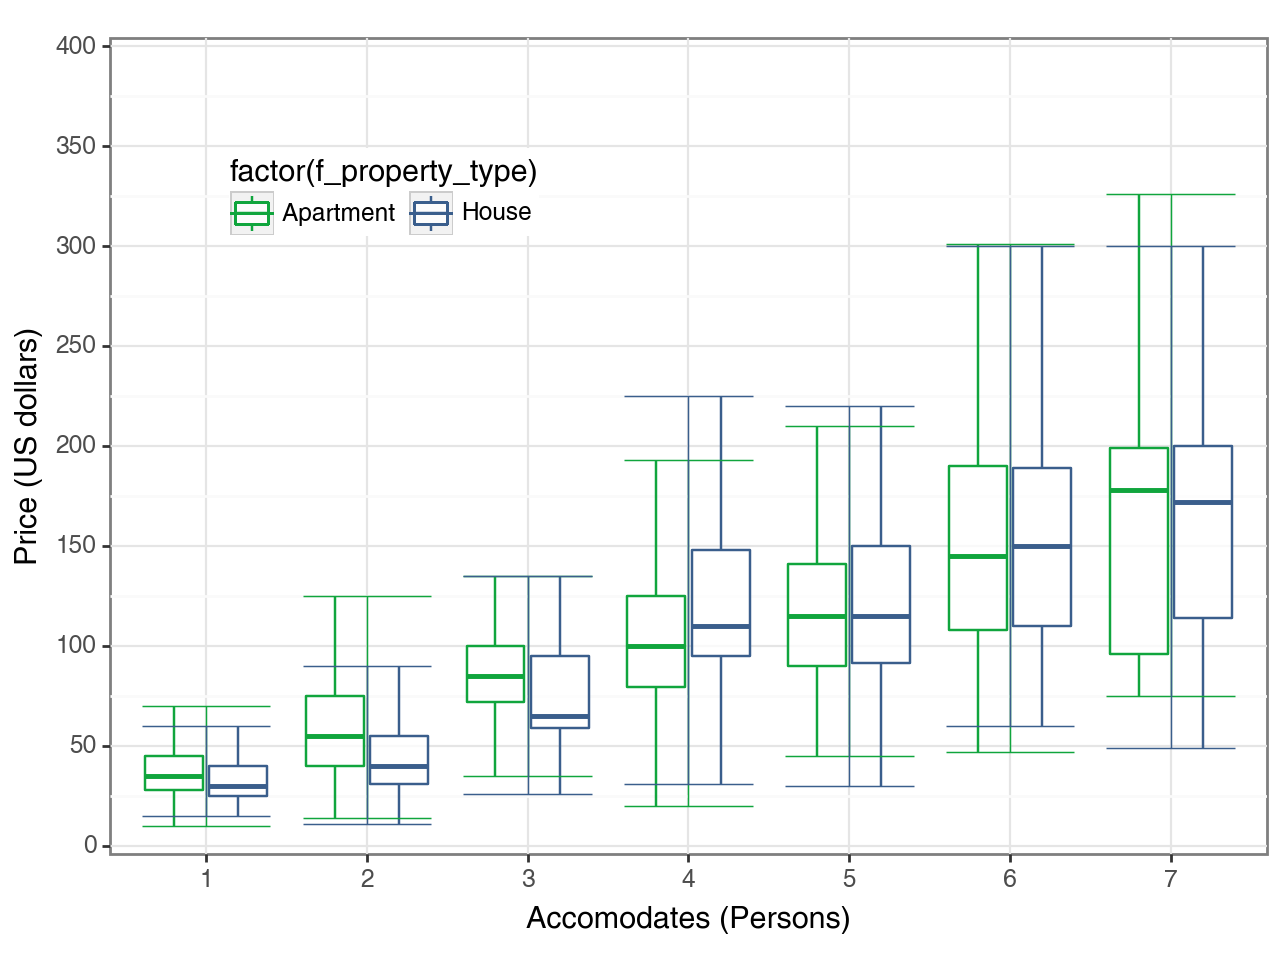

<Figure Size: (640 x 480)>

In [36]:
(
    ggplot(
        datau,
        aes(
            x="factor(n_accommodates)",
            y="price",
            # fill="factor(f_property_type)",
            color="factor(f_property_type)",
        ),
    )
    + geom_boxplot(alpha=0.8, na_rm=True, outlier_shape="", width=0.8, stat="boxplot")
    + stat_boxplot(geom="errorbar", width=0.8, size=0.3, na_rm=True)
    + scale_color_manual(name="", values=(color[1], color[0]))
    + scale_fill_manual(name="", values=(color[1], color[0]))
    + labs(x="Accomodates (Persons)", y="Price (US dollars)")
    + scale_y_continuous(expand=(0.01, 0.01), limits=(0, 400), breaks=seq(0, 401, 50))
    + theme_bw()
    + theme(legend_position=(0.3, 0.8))
)

### Modelling

**Basic variables**

In [38]:
basic_lev = (
    "n_accommodates",
    "n_beds",
    "f_property_type",
    "f_room_type",
    "n_days_since",
    "flag_days_since",
)
basic_add = ("f_bathroom", "f_cancellation_policy", "f_bed_type")
reviews = ("f_number_of_reviews", "n_review_scores_rating", "flag_review_scores_rating")
poly_lev = ("n_accommodates2", "n_days_since2", "n_days_since3")
# not use p_host_response_rate due to missing obs
amenities = list(data.filter(regex="^d_.*"))

In [39]:
amenities

['d_reviews_per_month',
 'd_24hourcheckin',
 'd_airconditioning',
 'd_breakfast',
 'd_buzzerwirelessintercom',
 'd_cabletv',
 'd_carbonmonoxidedetector',
 'd_cats',
 'd_dogs',
 'd_doorman',
 'd_doormanentry',
 'd_dryer',
 'd_elevatorinbuilding',
 'd_essentials',
 'd_familykidfriendly',
 'd_fireextinguisher',
 'd_firstaidkit',
 'd_freeparkingonpremises',
 'd_freeparkingonstreet',
 'd_gym',
 'd_hairdryer',
 'd_hangers',
 'd_heating',
 'd_hottub',
 'd_indoorfireplace',
 'd_internet',
 'd_iron',
 'd_keypad',
 'd_kitchen',
 'd_laptopfriendlyworkspace',
 'd_lockonbedroomdoor',
 'd_lockbox',
 'd_otherpets',
 'd_paidparkingoffpremises',
 'd_petsallowed',
 'd_petsliveonthisproperty',
 'd_pool',
 'd_privateentrance',
 'd_privatelivingroom',
 'd_safetycard',
 'd_selfcheckin',
 'd_shampoo',
 'd_smartlock',
 'd_smokedetector',
 'd_smokingallowed',
 'd_suitableforevents',
 'd_tv',
 'd_washer',
 'd_washerdryer',
 'd_wheelchairaccessible']

**Interactions**


In [40]:
## Helper functions

def price_diff_by_variables(df, factor_var, dummy_var):
    stats = df.groupby([factor_var, dummy_var]).agg(
        Mean=("price", np.mean), sd=("price", np.std), size=("price", "size")
    )
    stats["se"] = stats["sd"] / stats["size"] ** (1 / 2)
    stats["Mean_l"] = stats["Mean"] - (1.96 * stats["se"])
    stats["Mean_u"] = stats["Mean"] + (1.96 * stats["se"])
    stats = stats.drop(["sd", "size"], axis=1).reset_index()
    plot = (
        ggplot(
            stats,
            aes(
                stats.columns[0],
                stats.columns[2],
                fill="factor(" + stats.columns[1] + ")",
            ),
        )
        + geom_bar(stat="identity", position=position_dodge(width=0.9))
        + geom_errorbar(
            aes(ymin="Mean_l", ymax="Mean_u"),
            position=position_dodge(width=0.9),
            width=0.25,
        )
        + ylab("Mean Price")
        + theme_bw()
        + theme(
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank(),
            panel_border=element_blank(),
            axis_line=element_line(),
        )
        + scale_fill_grey()
    )

    return plot


def price_diff_by_variables2(df, factor_var, dummy_var, factor_lab, dummy_lab):
    stats = df.groupby([factor_var, dummy_var]).agg(
        Mean=("price", np.mean), sd=("price", np.std), size=("price", "size")
    )
    stats["se"] = stats["sd"] / stats["size"] ** (1 / 2)
    stats["Mean_l"] = stats["Mean"] - (1.96 * stats["se"])
    stats["Mean_u"] = stats["Mean"] + (1.96 * stats["se"])
    stats = stats.drop(["sd", "size"], axis=1).reset_index()
    plot = (
        ggplot(
            stats,
            aes(
                stats.columns[0],
                stats.columns[2],
                fill="factor(" + stats.columns[1] + ")",
            ),
        )
        + geom_bar(stat="identity", position=position_dodge(width=0.9))
        + geom_errorbar(
            aes(ymin="Mean_l", ymax="Mean_u"),
            position=position_dodge(width=0.9),
            width=0.25,
        )
        + scale_color_manual(name=dummy_lab, values=(color[1], color[0]))
        + scale_fill_manual(name=dummy_lab, values=(color[1], color[0]))
        + ylab("Mean Price")
        + xlab(factor_lab)
        + theme_bw()
        + theme(
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank(),
            panel_border=element_blank(),
            axis_line=element_line(),
            legend_position="top",
            legend_box="vertical",
            legend_text=element_text(size=5),
            legend_title=element_text(size=5, face="bold"),
        )
    )

    return plot

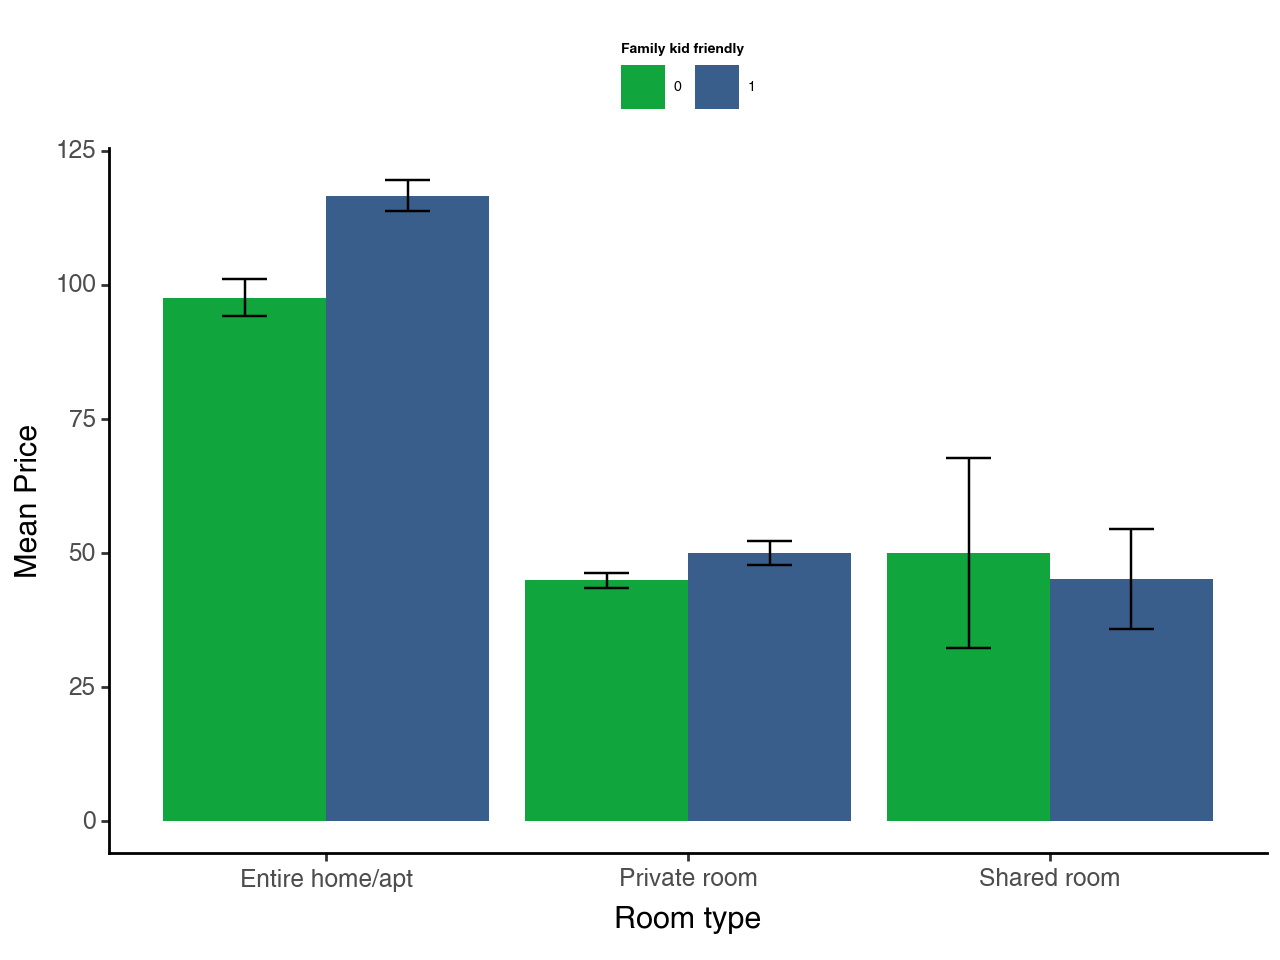

<Figure Size: (640 x 480)>

In [41]:
price_diff_by_variables2(data,"f_room_type","d_familykidfriendly","Room type", "Family kid friendly")

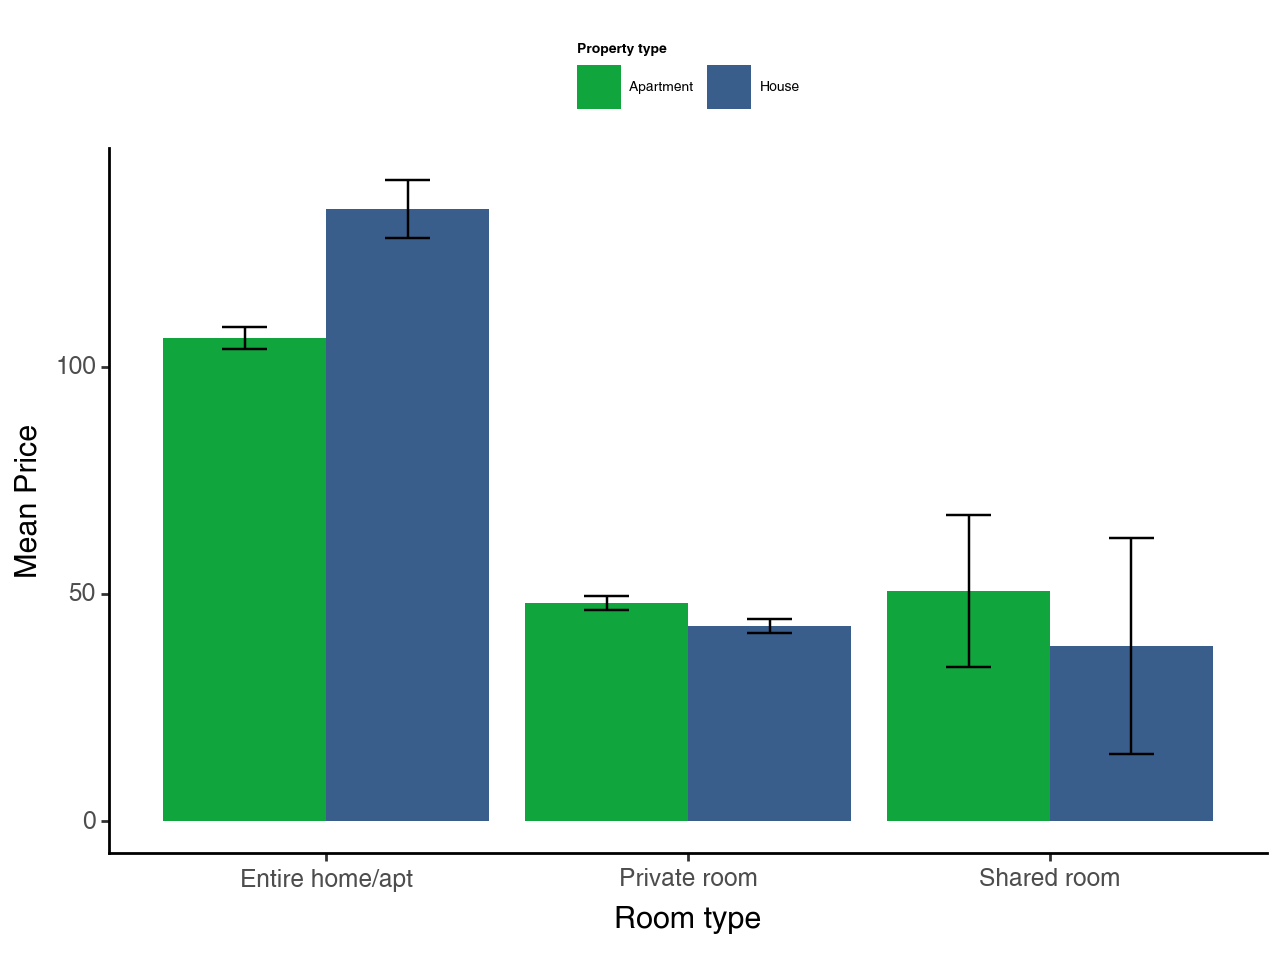

<Figure Size: (640 x 480)>

In [42]:
price_diff_by_variables2(data, "f_room_type", "f_property_type", "Room type", "Property type")

Cancelation policy

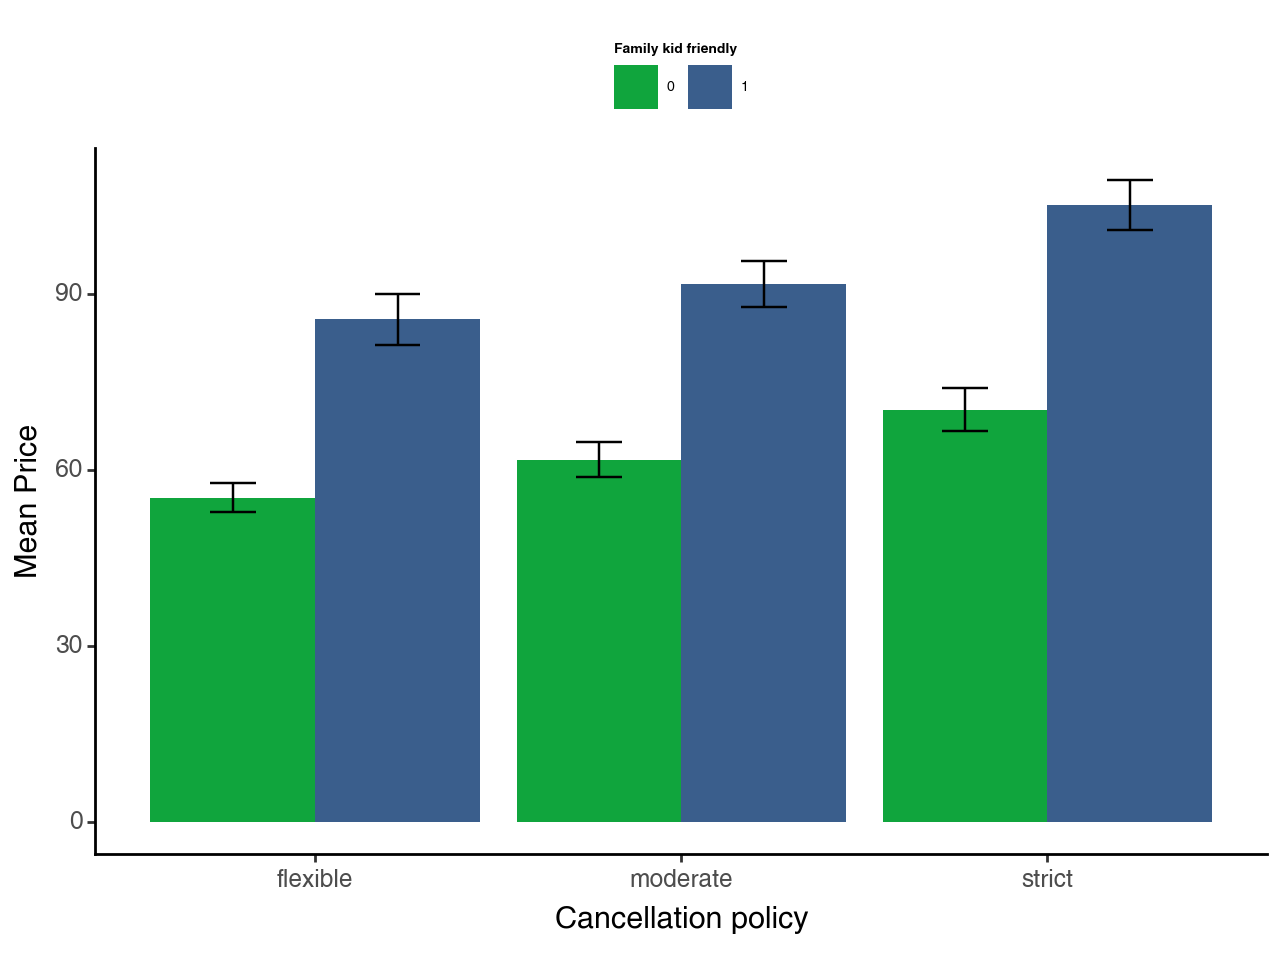

<Figure Size: (640 x 480)>

In [43]:
price_diff_by_variables2(data, "f_cancellation_policy", "d_familykidfriendly", "Cancellation policy", "Family kid friendly")

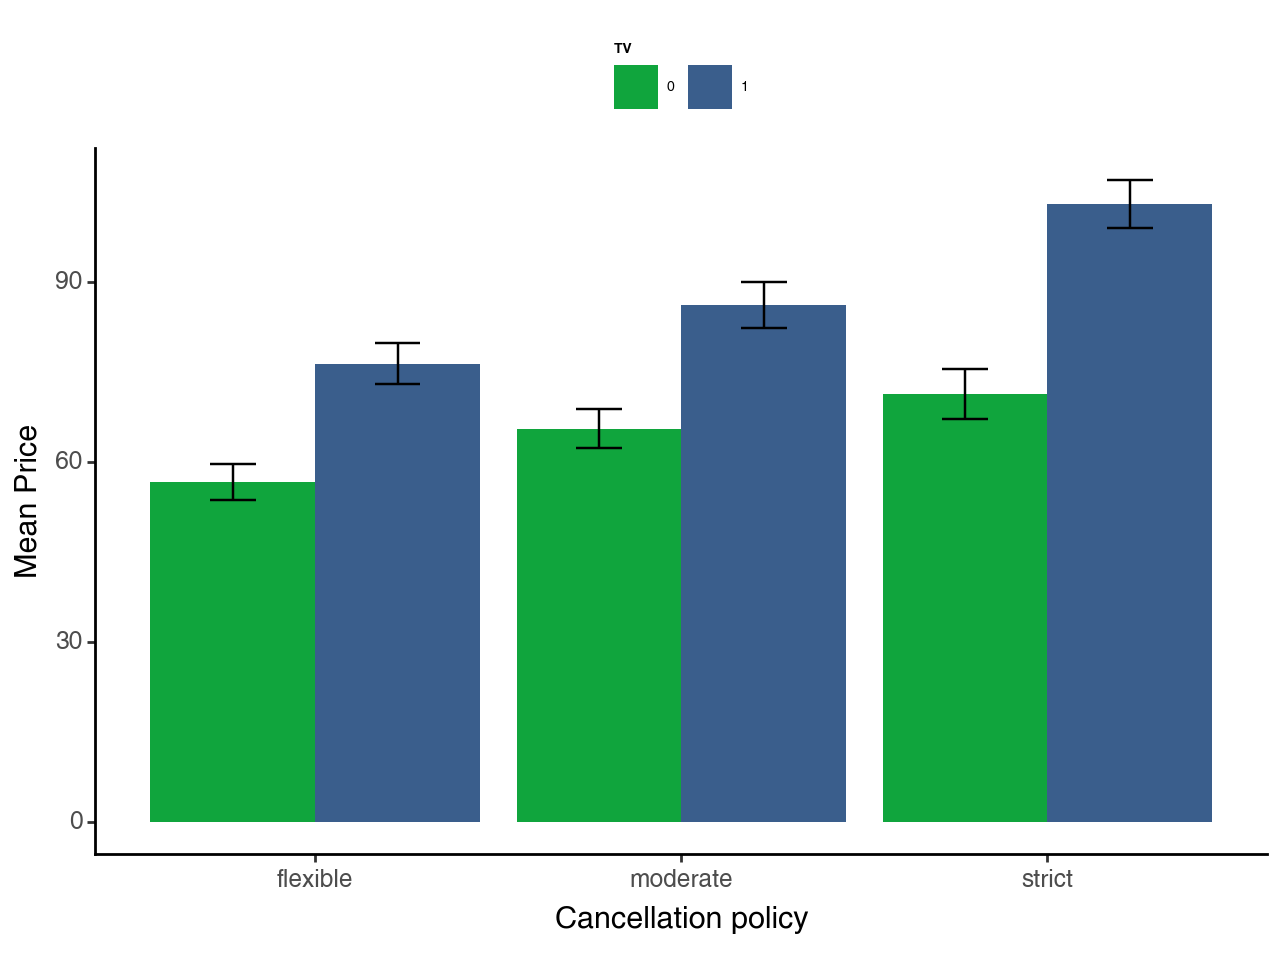

<Figure Size: (640 x 480)>

In [47]:
price_diff_by_variables2(data, "f_cancellation_policy", "d_tv", "Cancellation policy", "TV")

Look up property type

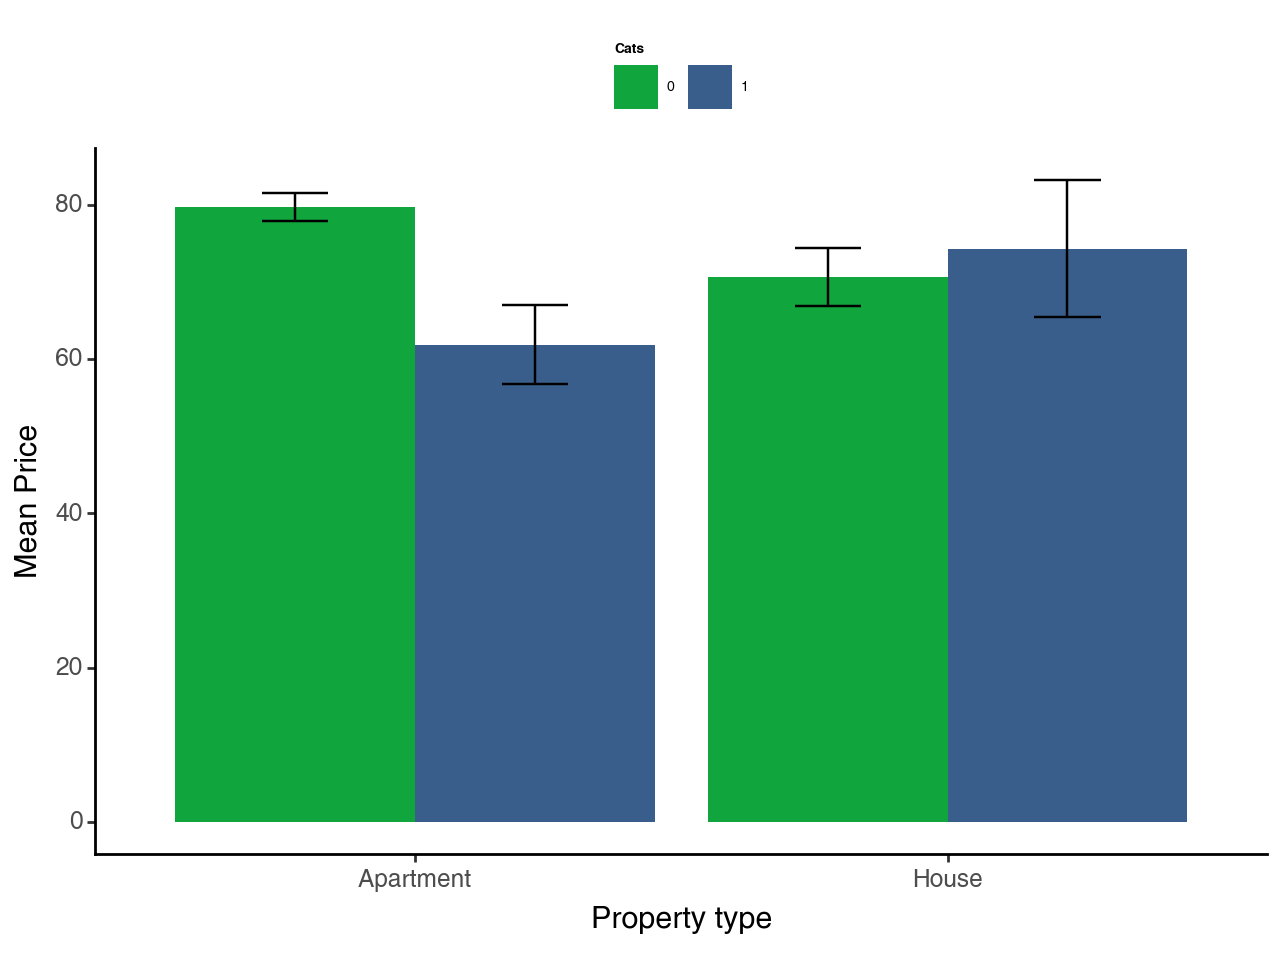

<Figure Size: (640 x 480)>

In [45]:
price_diff_by_variables2(data, "f_property_type", "d_cats", "Property type", "Cats")

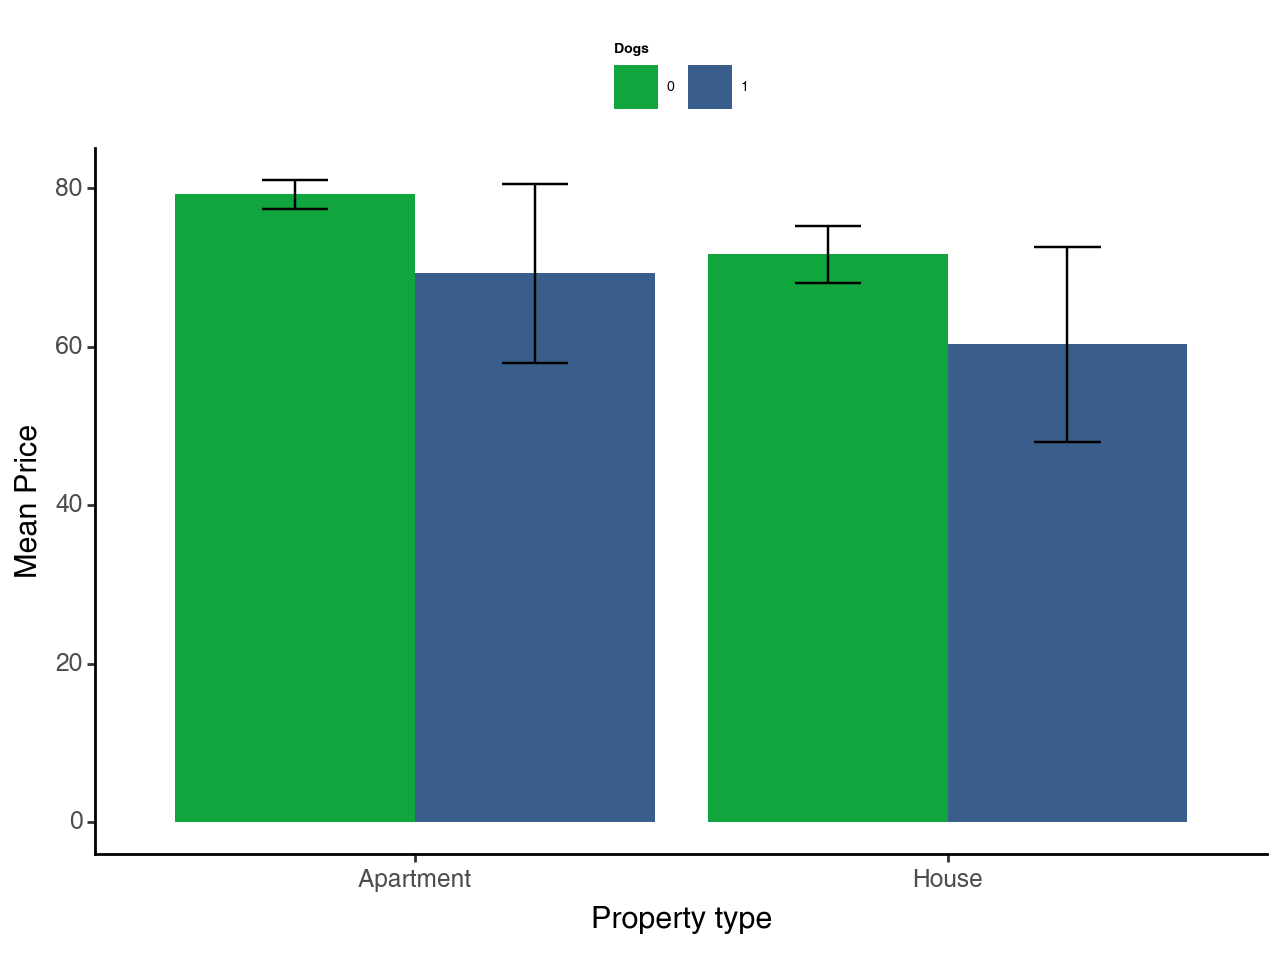

<Figure Size: (640 x 480)>

In [46]:
price_diff_by_variables2(data, "f_property_type", "d_dogs", "Property type", "Dogs")

**Dummies, interactions suggested by graphs**

In [48]:
X1 = ("f_room_type*f_property_type",  "f_room_type*d_familykidfriendly")
X2=("d_airconditioning*f_property_type", "d_cats*f_property_type", "d_dogs*f_property_type")
X3="(f_property_type + f_room_type + f_cancellation_policy + f_bed_type) * ("+ "+".join(amenities) +")"

In [50]:
modellev1="~ n_accommodates"
modellev2="~"+"+".join(basic_lev)
modellev3="~"+"+".join(basic_lev)+"+"+"+".join(basic_add)+"+"+"+".join(reviews)
modellev4="~"+"+".join(basic_lev)+"+"+"+".join(basic_add)+"+"+"+".join(reviews)+"+"+"+".join(poly_lev)
modellev5="~"+"+".join(basic_lev)+"+"+"+".join(basic_add)+"+"+"+".join(reviews)+"+"+"+".join(poly_lev)+"+"+"+".join(X1)
modellev6="~"+"+".join(basic_lev)+"+"+"+".join(basic_add)+"+"+"+".join(reviews)+"+"+"+".join(poly_lev)+"+"+"+".join(X1)+"+"+"+".join(X2)
modellev7="~"+"+".join(basic_lev)+"+"+"+".join(basic_add)+"+"+"+".join(reviews)+"+"+"+".join(poly_lev)+"+"+"+".join(X1)+"+"+"+".join(X2)+"+"+"+".join(amenities)
modellev8="~"+"+".join(basic_lev)+"+"+"+".join(basic_add)+"+"+"+".join(reviews)+"+"+"+".join(poly_lev)+"+"+"+".join(X1)+"+"+"+".join(X2)+"+"+"+".join(amenities)+"+"+X3

In [63]:
modellev2

'~n_accommodates+n_beds+f_property_type+f_room_type+n_days_since+flag_days_since'

#### Regressions with cross-validation

**Split train & holdout for cross-validation**

In [64]:
smp_size = round(0.2 * data.shape[0])-1

In [65]:
smp_size

878

In [66]:
# Set the seed to make results reproducable
np.random.seed(20240115)

In [67]:
from sklearn.model_selection import train_test_split

In [68]:
data_work,data_holdout=train_test_split(data, test_size=smp_size)

In [69]:
data_work.shape

(3515, 91)

In [57]:
data_holdout.shape

(878, 91)

In [58]:
n_folds=5

In [72]:
from sklearn.model_selection import KFold
from statsmodels.tools.eval_measures import mse,rmse
k = KFold(n_splits=n_folds, shuffle=False, random_state=None)

In [71]:
def cv_reg(formula, data, kfold, testdata, robustse=None):
    regression_list = []
    predicts_on_test = []
    rsquared = []
    rmse_list = []
    rmse_list_test = []

    # Calculating OLS for each fold

    for train_index, test_index in k.split(data):
        data_train, data_test = data.iloc[train_index, :], data.iloc[test_index, :]
        if robustse is None:
            model = smf.ols(formula, data=data_train).fit()
        else:
            model = smf.ols(formula, data=data_train).fit(cov_type=robustse)
        regression_list += [model]
        predicts_on_test += [model.predict(data_test)]
        rsquared += [model.rsquared]

        rmse_tr = pd.concat(
            [data_train["price"], model.predict(data_train)],
            axis=1,
            keys=["price", "predicted"],
        )
        rmse_tr = rmse_tr[~rmse_tr.isna().any(axis=1)]

        rmse_te = pd.concat(
            [data_test["price"], model.predict(data_test)],
            axis=1,
            keys=["price", "predicted"],
        )
        rmse_te = rmse_te[~rmse_te.isna().any(axis=1)]

        rmse_list += [rmse(rmse_tr["price"], rmse_tr["predicted"], axis=0)]
        rmse_list_test += [rmse(rmse_te["price"], rmse_te["predicted"], axis=0)]
    nvars = model.df_model

    return {
        "regressions": regression_list,
        "test_predict": predicts_on_test,
        "r2": rsquared,
        "rmse": rmse_list,
        "rmse_test": rmse_list_test,
        "nvars": nvars,
    }


def summarize_cv(cvlist, stat="rmse"):
    result = pd.DataFrame(
        {"Model" + str(x + 1): cvlist[x][stat] for x in range(len(cvlist))}
    )
    result["Resample"] = ["Fold" + str(x + 1) for x in range(len(cvlist[0]["rmse"]))]
    result = result.set_index("Resample")
    result = pd.concat([result, pd.DataFrame(result.mean(), columns=["Average"]).T])
    return result

In [61]:
cv_list = []
for i in [
    modellev1,
    modellev2,
    modellev3,
    modellev4,
    modellev5,
    modellev6,
    modellev7,
    modellev8,
]:
    cv_list += [cv_reg("price" + i, data, k, "HC0")]

In [62]:
summarize_cv(cv_list)


,Model1,Model2,Model3,Model4,Model5,Model6,Model7,Model8
Fold1,42.224944,39.335372,38.279636,34.844526,34.770972,34.623380,33.606961,31.694854
Fold2,42.066027,39.238050,38.354196,33.955907,33.778094,33.648667,32.688787,30.908968
Fold3,38.938911,36.070842,35.282251,33.507214,33.397693,33.251641,32.338406,30.673270
Fold4,40.730742,38.290893,37.324689,32.407741,32.314413,32.091116,30.931761,28.860550
Fold5,42.228597,39.493288,38.582335,35.572399,35.458907,35.331049,34.217780,32.212682
Average,41.237844,38.485689,37.564621,34.057558,33.944016,33.789171,32.756739,30.870065


In [73]:
# RMSE training vs test graph

rmse_levels = {"nvars": [], "var": [], "value": []}
for i in range(0, 8):
    rmse_levels["nvars"].append(int(cv_list[i]["nvars"]))
    rmse_levels["var"].append("RMSE Training")
    rmse_levels["value"].append(pd.Series(cv_list[i]["rmse"]).mean())
for i in range(0, 8):
    rmse_levels["nvars"].append(int(cv_list[i]["nvars"]))
    rmse_levels["var"].append("RMSE Test")
    rmse_levels["value"].append(pd.Series(cv_list[i]["rmse_test"]).mean())
rmse_levels = pd.DataFrame.from_dict(rmse_levels)
rmse_levels["nvars2"] = rmse_levels["nvars"] + 1

In [74]:
rmse_levels

,nvars,var,value,nvars2
0,1,RMSE Training,41.237844,2
1,7,RMSE Training,38.485689,8
2,14,RMSE Training,37.564621,15
3,16,RMSE Training,34.057558,17
4,21,RMSE Training,33.944016,22
5,27,RMSE Training,33.789171,28
6,71,RMSE Training,32.756739,72
7,293,RMSE Training,30.870065,294
8,1,RMSE Test,41.029270,2
9,7,RMSE Test,38.426556,8


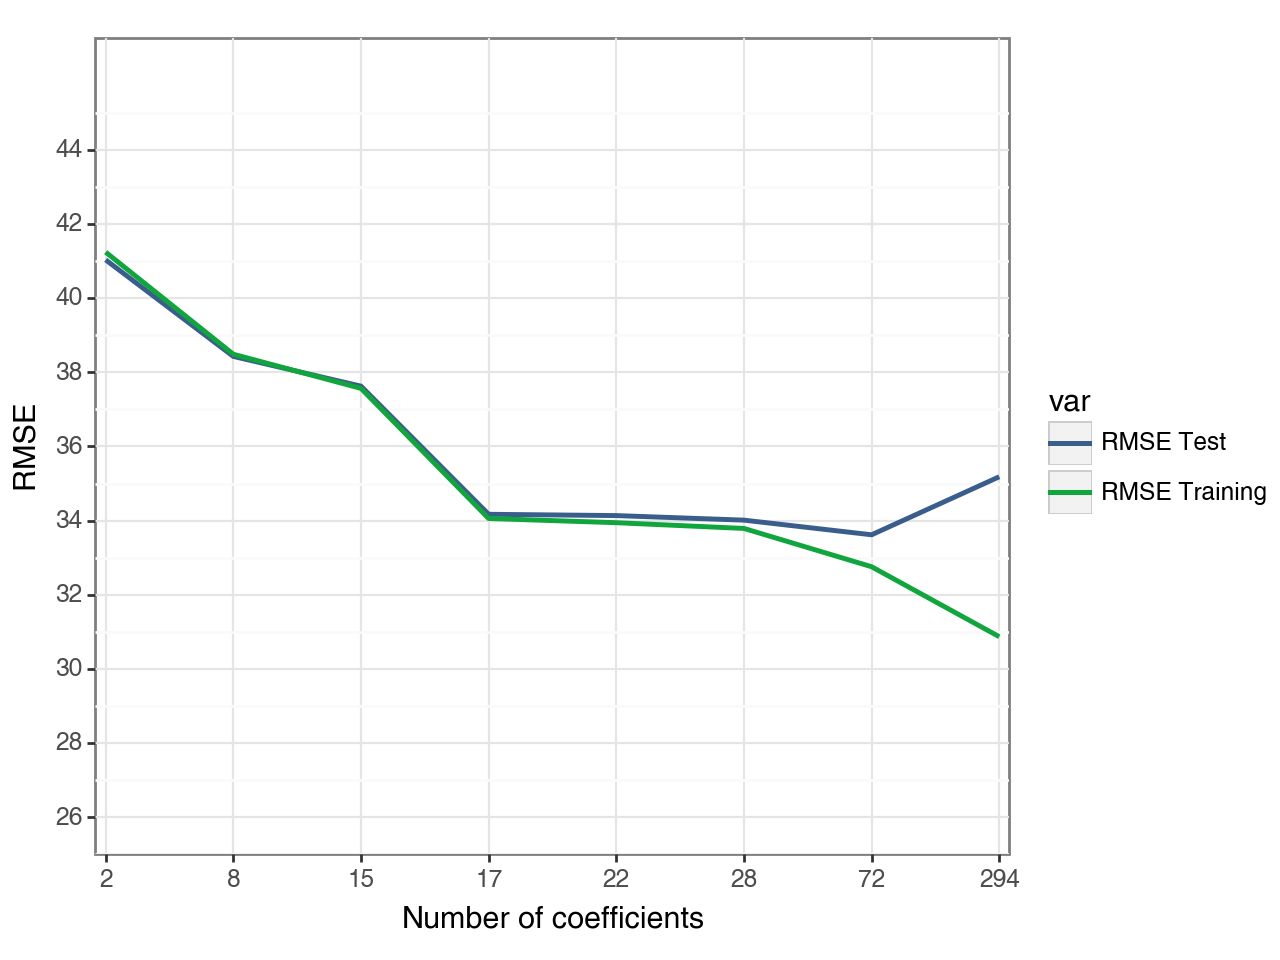

<Figure Size: (640 x 480)>

In [75]:
(
    ggplot(rmse_levels, aes(x="factor(nvars2)", y="value", color="var", group="var"))
    + geom_line(size=1, show_legend=True, na_rm=True)
    + scale_color_manual(name="", values=(color[0], color[1]))
    + scale_y_continuous(name="RMSE", limits=(26, 46), breaks=seq(26, 46, 2))
    + scale_x_discrete(
        name="Number of coefficients",
        expand=(0.01, 0.01)
    )
    + theme_bw()
)

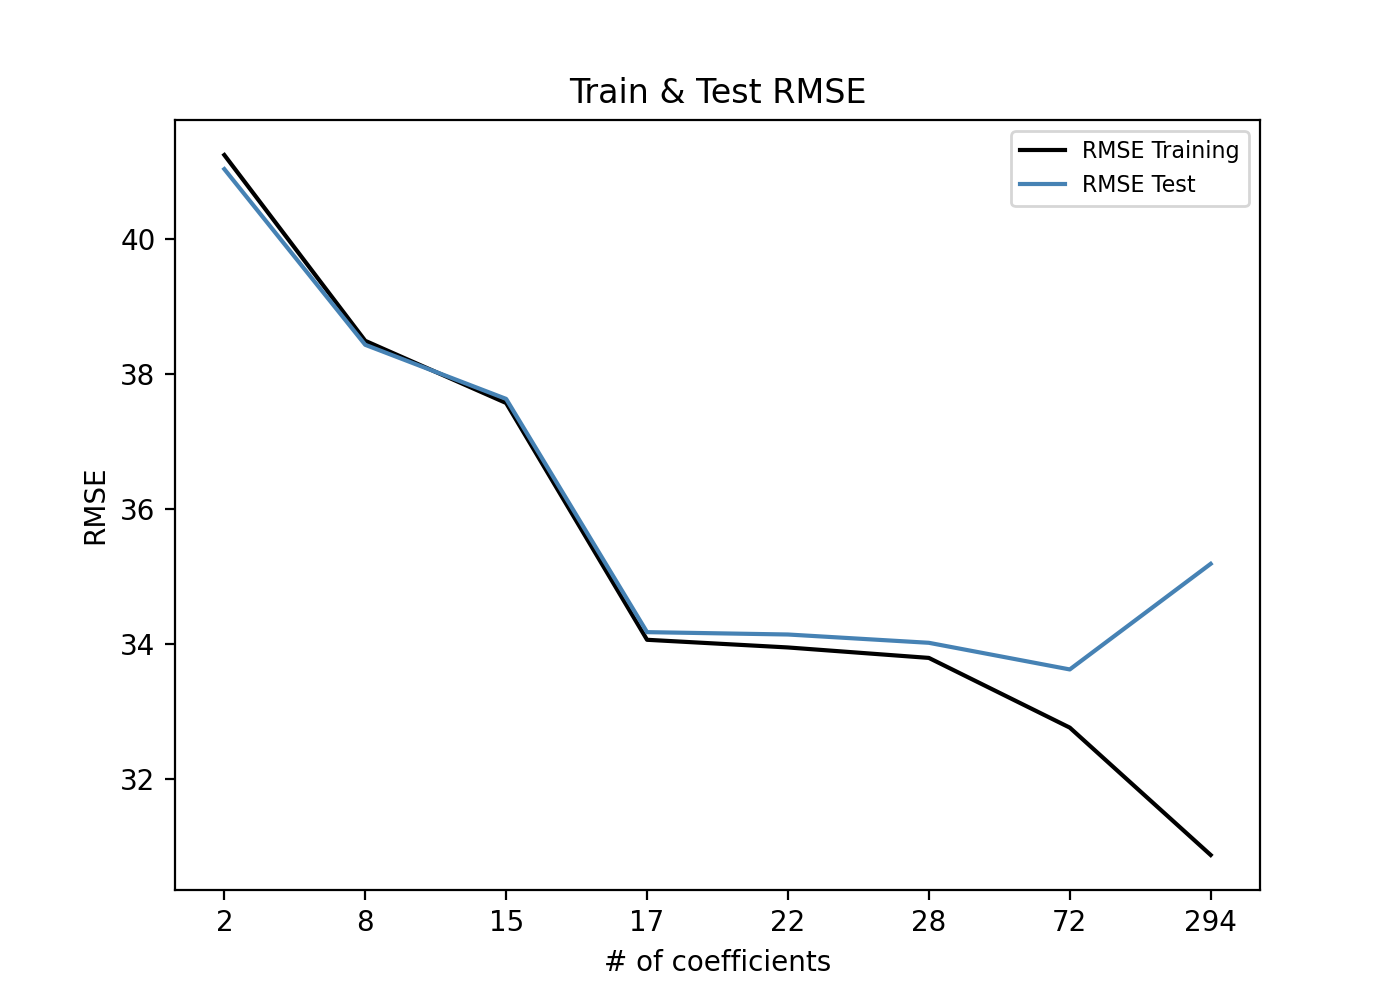

In [76]:
plt.figure(figsize=(7,5))
ax = sns.lineplot(
    x = [str(x) for x in rmse_levels['nvars2']], 
    y = rmse_levels['value'], 
    hue = rmse_levels['var'],
    palette = ['k', 'steelblue']
)
ax.set_title('Train & Test RMSE')
ax.set_ylabel('RMSE')
ax.set_xlabel('# of coefficients')
ax.legend(fontsize = 8, title = None)
plt.show();

#### LASSO

**Doing LASSO the hard way (aka *'naive' grid search*)**

In [77]:
vars_model_7 = "(f_property_type + f_room_type + f_cancellation_policy + f_bed_type) * (d_24hourcheckin + d_airconditioning + d_breakfast + d_buzzerwirelessintercom + d_cabletv + d_carbonmonoxidedetector + d_cats + d_dogs + d_doorman + d_doormanentry + d_dryer + d_elevatorinbuilding + d_essentials + d_familykidfriendly + d_fireextinguisher + d_firstaidkit + d_freeparkingonpremises + d_freeparkingonstreet + d_gym + d_hairdryer + d_hangers + d_heating + d_hottub + d_indoorfireplace + d_internet + d_iron + d_keypad + d_kitchen + d_laptopfriendlyworkspace + d_lockonbedroomdoor + d_lockbox + d_otherpets + d_paidparkingoffpremises + d_petsallowed + d_petsliveonthisproperty + d_pool + d_privateentrance + d_privatelivingroom + d_safetycard + d_selfcheckin + d_shampoo + d_smartlock + d_smokedetector + d_smokingallowed + d_suitableforevents + d_tv + d_washer + d_washerdryer + d_wheelchairaccessible + d_wirelessinternet)"
vars_model_8 = modellev8

In [78]:
from sklearn.linear_model import Lasso
import patsy
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler

# define model evaluation method
cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)
y, X = patsy.dmatrices("price" + vars_model_8, data)

In [79]:
y

DesignMatrix with shape (3073, 1)
  price
     65
     30
    150
     29
     65
    165
     95
     65
     28
     95
     25
    175
     95
     80
     30
     29
     38
     30
    190
    115
     35
     79
    100
     69
     60
     29
     55
     33
     39
     95
  [3043 rows omitted]
  Terms:
    'price' (column 0)
  (to view full data, use np.asarray(this_obj))

In [80]:
X.shape

(3073, 370)

In [90]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=smp_size, random_state=10
)

lambdas = [i/100 for i in range(5, 100,5)]

train_r_squared = np.zeros(len(lambdas))
test_r_squared = np.zeros(len(lambdas))

pred_num = X.shape[1]
coeff_a = np.zeros((len(lambdas), pred_num))

In [91]:
import datetime

In [83]:
from sklearn.model_selection import cross_val_score

for ind, i in enumerate(lambdas):
    print(f"Run: {str(ind).rjust(2)}, lambda: {i:.2f}, start: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    reg = Lasso(alpha = i, random_state= 20240115)
    reg.fit(X_train, y_train)
    results = cross_val_score(reg, X, y, cv=cv, scoring="r2")

    train_r_squared[ind] = reg.score(X_train, y_train)    
    test_r_squared[ind] = reg.score(X_test, y_test)

Run:  0, lambda: 0.05, start: 2024-01-15 19:05:55
Run:  1, lambda: 0.10, start: 2024-01-15 19:05:58
Run:  2, lambda: 0.15, start: 2024-01-15 19:05:59
Run:  3, lambda: 0.20, start: 2024-01-15 19:06:00
Run:  4, lambda: 0.25, start: 2024-01-15 19:06:01
Run:  5, lambda: 0.30, start: 2024-01-15 19:06:02
Run:  6, lambda: 0.35, start: 2024-01-15 19:06:03
Run:  7, lambda: 0.40, start: 2024-01-15 19:06:03
Run:  8, lambda: 0.45, start: 2024-01-15 19:06:04
Run:  9, lambda: 0.50, start: 2024-01-15 19:06:05
Run: 10, lambda: 0.55, start: 2024-01-15 19:06:05
Run: 11, lambda: 0.60, start: 2024-01-15 19:06:06
Run: 12, lambda: 0.65, start: 2024-01-15 19:06:06
Run: 13, lambda: 0.70, start: 2024-01-15 19:06:07
Run: 14, lambda: 0.75, start: 2024-01-15 19:06:07
Run: 15, lambda: 0.80, start: 2024-01-15 19:06:08
Run: 16, lambda: 0.85, start: 2024-01-15 19:06:08
Run: 17, lambda: 0.90, start: 2024-01-15 19:06:09
Run: 18, lambda: 0.95, start: 2024-01-15 19:06:09


In [92]:
r_squared_data = (
    pd.DataFrame(
        {
            "$R^2$ Test set": test_r_squared,
            "$R^2$ Training set": train_r_squared,
            "lambda": lambdas,
        }
    )
    .melt(id_vars=["lambda"])
)

In [93]:
r_squared_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   lambda    38 non-null     float64
 1   variable  38 non-null     object 
 2   value     38 non-null     float64
dtypes: float64(2), object(1)
memory usage: 1.0+ KB


In [94]:
r_squared_data["variable"] = r_squared_data["variable"].astype("category").cat.reorder_categories(
    ["$R^2$ Training set", "$R^2$ Test set"]
)

In [95]:
r_squared_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   lambda    38 non-null     float64 
 1   variable  38 non-null     category
 2   value     38 non-null     float64 
dtypes: category(1), float64(2)
memory usage: 902.0 bytes


#### Plot results using `ggplot` and `seaborn`

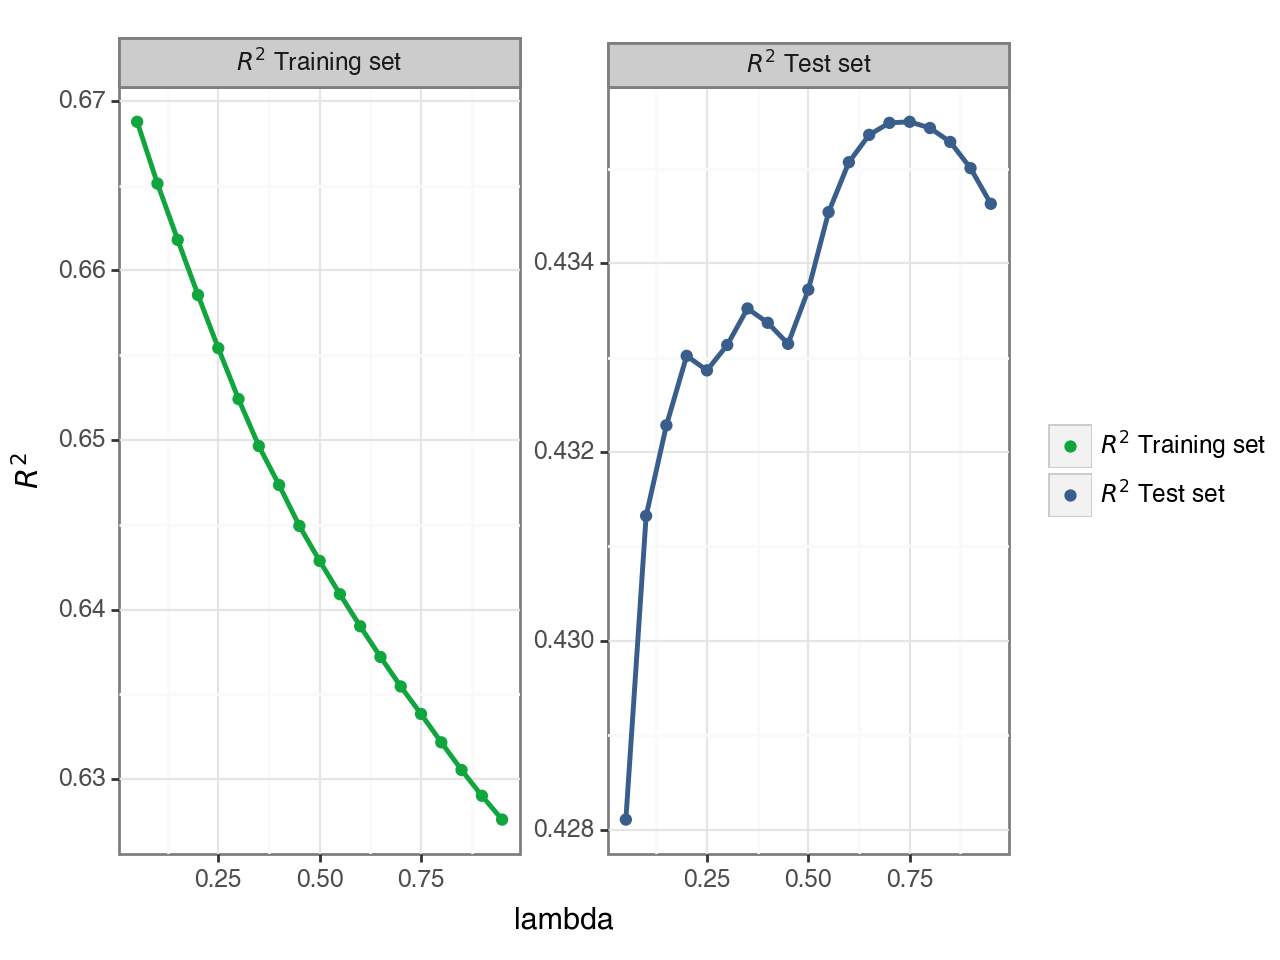

<Figure Size: (640 x 480)>

In [89]:
(
    ggplot(r_squared_data, aes(x="lambda", y="value", color="variable"))
    + geom_point()
    + geom_line(size=1, show_legend=False, na_rm=True)
    + scale_color_manual(name="", values=(color[1], color[0]))
    + scale_y_continuous(name="$R^2$")
    + facet_wrap("variable", scales="free")
    + theme_bw()
    + theme(subplots_adjust={"wspace": 0.25},legend_title=element_blank())
)

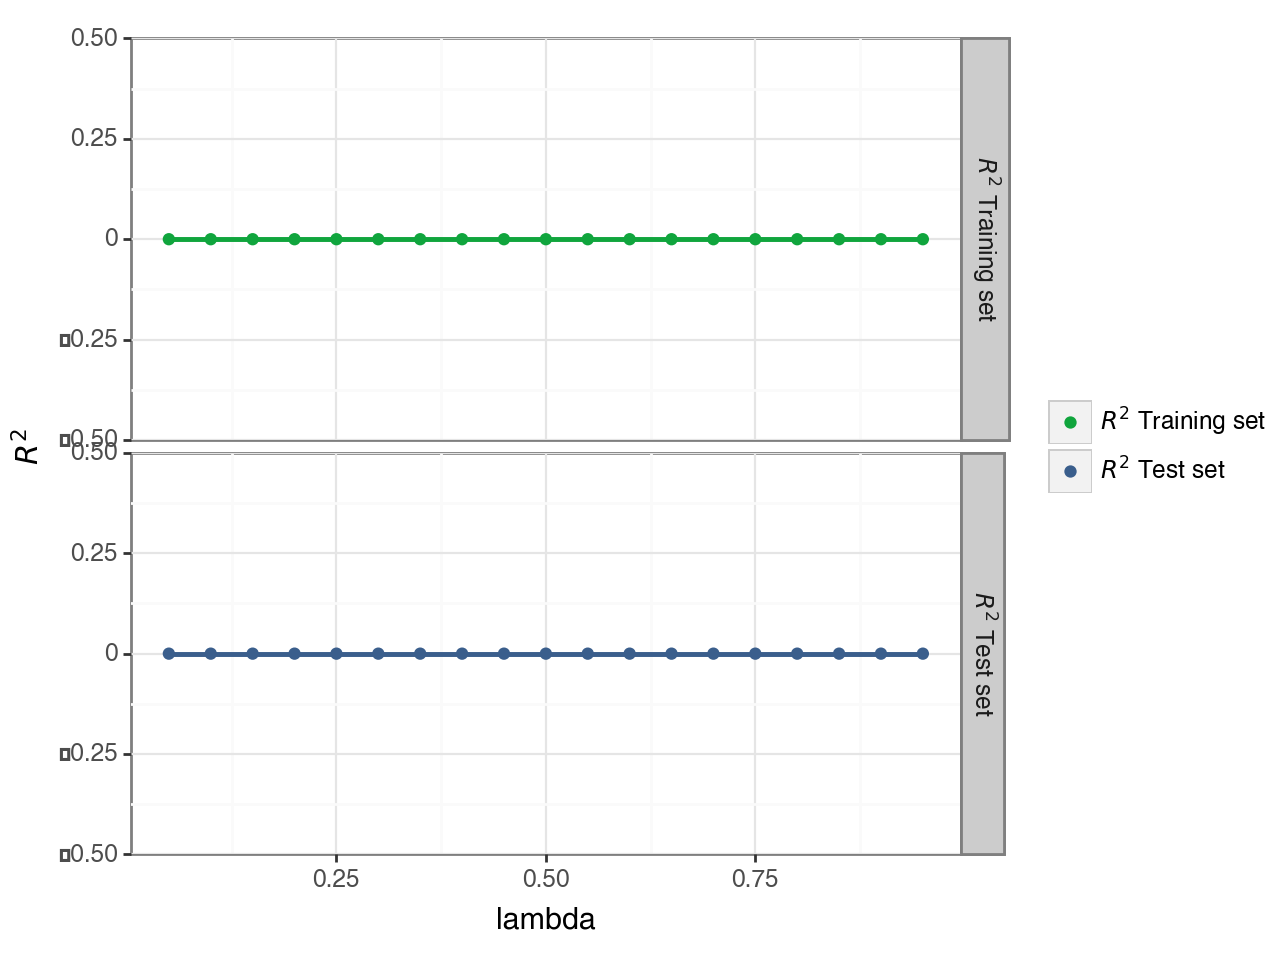

<Figure Size: (640 x 480)>

In [96]:
(
    ggplot(r_squared_data, aes(x="lambda", y="value", color="variable"))
    + geom_point()
    + geom_line(size=1, show_legend=False, na_rm=True)
    + scale_color_manual(name="", values=(color[1], color[0]))
    + scale_y_continuous(name="$R^2$")
    + facet_grid("variable ~ .", scales="free")
    + theme_bw()
    + theme(subplots_adjust={"wspace": 0.25}, legend_title=element_blank())
)

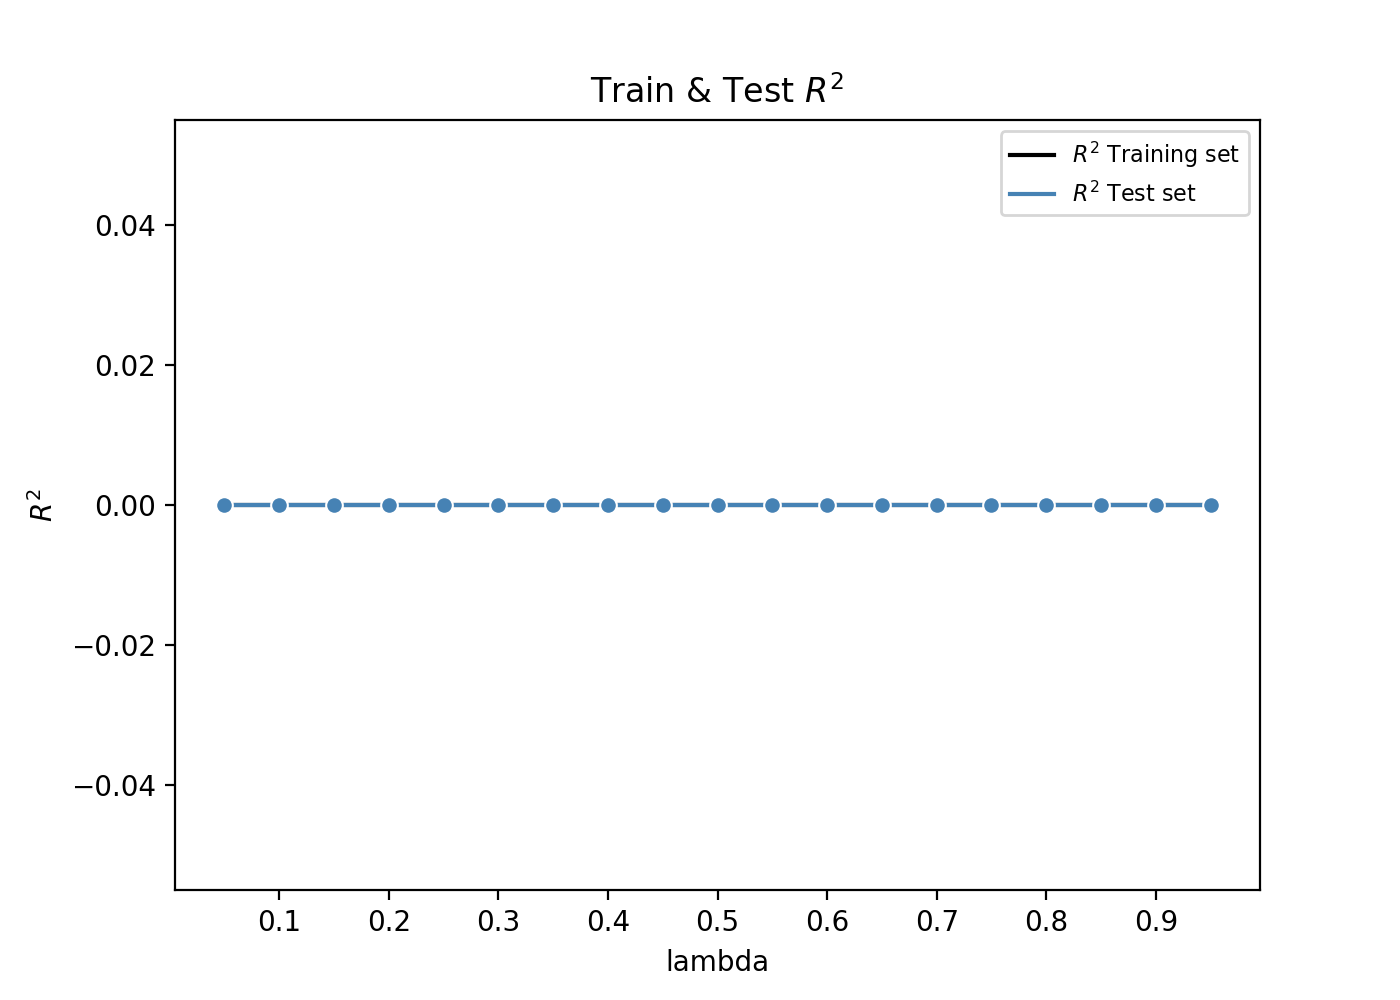

In [97]:
plt.figure(figsize=(7,5))
ax = sns.lineplot(
    data = r_squared_data, 
    x = 'lambda', y = 'value', hue = 'variable', 
    palette = ['k', 'steelblue'],
    marker = 'o'
)
ax.set_title('Train & Test $R^2$')
ax.set_ylabel('$R^2$')
ax.set_xlabel('lambda')
ax.set_xticks(lambdas[1::2])
ax.legend(fontsize = 8, title = None)
plt.show();

In [98]:
df_lam = pd.DataFrame(test_r_squared*100, columns=['R_squared'])
df_lam['lambda'] = (lambdas)
# returns the index of the row where column has maximum value.
df_lam.loc[df_lam['R_squared'].idxmax()]

R_squared    0.00
lambda       0.05
Name: 0, dtype: float64

In [99]:
reg_best = Lasso(alpha = df_lam.loc[df_lam['R_squared'].idxmax()]['lambda'])
reg_best.fit(X_train, y_train)

Lasso(alpha=0.05)

In [100]:
reg_best.coef_[reg_best.coef_>0]

array([2.03034436e+00, 4.18920112e+00, 1.14953386e+00, 1.59783099e+00,
       7.92589821e+00, 6.37642679e-01, 1.78772160e+00, 2.11389971e+01,
       1.51580750e+00, 1.98741539e-01, 6.13525313e-01, 6.02787001e-01,
       1.82304058e-01, 1.74658906e-01, 3.86299915e-01, 1.31091728e-01,
       8.94717438e-01, 1.80719443e-01, 5.78999221e-01, 1.34175660e-01,
       1.63469755e+00, 1.76763520e+00, 5.26649062e-01, 4.30821408e-01,
       3.84851433e-01, 5.62392066e-01, 1.72586881e+00, 1.49419855e-01,
       2.15052210e-01, 1.99120624e-01, 1.64591279e+00, 9.73735059e-01,
       3.94422667e-01, 1.16293823e+00, 1.26020714e+00, 1.50940739e-01,
       3.48898779e+00, 1.25285654e+00, 2.66705597e+00, 6.08020510e-01,
       1.65919370e+00, 3.17605142e+00, 1.79763415e+00, 3.36778823e-01,
       1.26009055e+00, 1.04738952e-01, 6.53870277e-01, 1.79509743e+00,
       1.30792959e+00, 2.06558368e+00, 1.31274682e+00, 6.78796161e-01,
       4.27399894e-01, 2.69249531e-01, 1.59332900e-01, 8.68257840e-02,
      

In [101]:
reg_best.get_params()

{'alpha': 0.05,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 1000,
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

In [103]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, reg_best.predict(X_test))

1685.978895654482

**LASSO using `GridSearch`**

- cross-validation strategies: https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation
- RepeatedKFold: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedKFold.html#sklearn.model_selection.RepeatedKFold
- scoring: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
- GridSearch: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [104]:
y,  X = patsy.dmatrices('price'+vars_model_8, data)

In [105]:
from sklearn.model_selection import GridSearchCV

`GridSearchCV` not only searches for the best parameters, but also automatically fits a new model on the whole training dataset with the parameters that yielded the best cross-validation performance.  

In [111]:
# define model
model = Lasso()
# define model evaluation method
cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)
# define grid
grid = dict()
grid["alpha"] = np.arange(0.05, 1, 0.05)
# define search
search = GridSearchCV(model, grid, scoring="neg_root_mean_squared_error", cv=cv)
# perform the search
results = search.fit(X, y)

In [107]:
print("RMSE: " + str(results.best_score_ * -1))

RMSE: 33.176197994784175


In [108]:
results.cv_results_['rank_test_score']

array([ 5,  1,  2,  3,  4,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])

In [109]:
results.best_estimator_

Lasso(alpha=0.1)

### Diagnostics 

In [112]:
model3_level = smf.ols('price'+modellev3, data=data_work).fit(cov_type='HC0')
model7_level = smf.ols('price'+modellev7, data=data_work).fit(cov_type='HC0')

In [113]:
# look at holdout RMSE
model7_level_work_predictions = pd.concat(
    [data_work["price"], model7_level.predict(data_work)],
    axis=1,
    keys=["price", "predicted"],
)

In [114]:
model7_level_work_predictions.tail()

,price,predicted
3796,108,151.330450
2155,299,111.740398
1259,100,100.218199
2411,55,NaN
557,90,NaN


In [115]:
model7_level_work_predictions = model7_level_work_predictions[~model7_level_work_predictions.isna().any(axis=1)]
model7_level_work_rmse = rmse(model7_level_work_predictions["price"], model7_level_work_predictions["predicted"], axis=0)

In [116]:
model7_level_work_rmse

34.17316988770989

In [117]:
model7_level_holdout_predictions = pd.concat(
    [data_holdout["price"], model7_level.predict(data_holdout)],
    axis=1,
    keys=["price", "predicted"],
)
model7_level_holdout_predictions = model7_level_holdout_predictions[~model7_level_holdout_predictions.isna().any(axis=1)]
model7_level_holdout_rmse = rmse(model7_level_holdout_predictions["price"], model7_level_holdout_predictions["predicted"], axis=0)
print(
    f"RMSE work:{round(model7_level_work_rmse,2)}",
    "\t",
    f"RMSE holdout:{model7_level_holdout_rmse:.2f}",
)

RMSE work:34.17 	 RMSE holdout:27.75


#### Charting fitted vs actual

In [118]:
Ylev=data_holdout['price']
meanY=Ylev.mean()
sdY=Ylev.std()
meanY_m2SE = meanY -1.96 * sdY
meanY_p2SE = meanY + 1.96 * sdY
Y5p=Ylev.quantile(.05)
Y95p=Ylev.quantile(.95)

Note: the `statsmodels` API is kind of reticent in its documentation. So much about the [summary_frame()](https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.PredictionResults.summary_frame.html#statsmodels.regression.linear_model.PredictionResults.summary_frame) method...

In [119]:
model7_level.get_prediction(data_holdout).summary_frame(alpha=0.05)

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,125.581743,5.956802,113.906626,137.256860,56.601530,194.561956
1,33.968045,3.632471,26.848533,41.087556,-34.388731,102.324821
2,101.451301,5.505682,90.660362,112.242240,32.615222,170.287380
3,30.552624,3.550929,23.592931,37.512317,-37.787691,98.892940
4,34.945811,4.405970,26.310268,43.581355,-33.585452,103.477075
...,...,...,...,...,...,...
619,81.232025,4.690600,72.038618,90.425433,12.628234,149.835816
620,92.728567,3.853340,85.176159,100.280975,24.325348,161.131785
621,64.969379,7.308223,50.645524,79.293233,-4.508202,134.446959
622,103.376239,3.588161,96.343573,110.408905,35.028453,171.724025


In [120]:
# Create data frame with the real and predicted values
data_diagnostic = model7_level.get_prediction(data_holdout).summary_frame(alpha=0.05)

df_ = pd.concat(
    [data_holdout["price"], model7_level.predict(data_holdout)],
    axis=1,
    keys=["price", "predicted"],
)

In [121]:
df_.isna().sum()

price          0
predicted    254
dtype: int64

In [122]:
df_ = df_[~df_.isna().any(axis=1)].reset_index(drop=True)
data_diagnostic["Ylev"] = df_["price"]

`pd.DataFrame.any()`: Return whether any element is True, potentially over an axis. 
Returns False unless there is at least one element within a series or along a Dataframe axis that is True or equivalent (e.g. non-zero or non-empty).

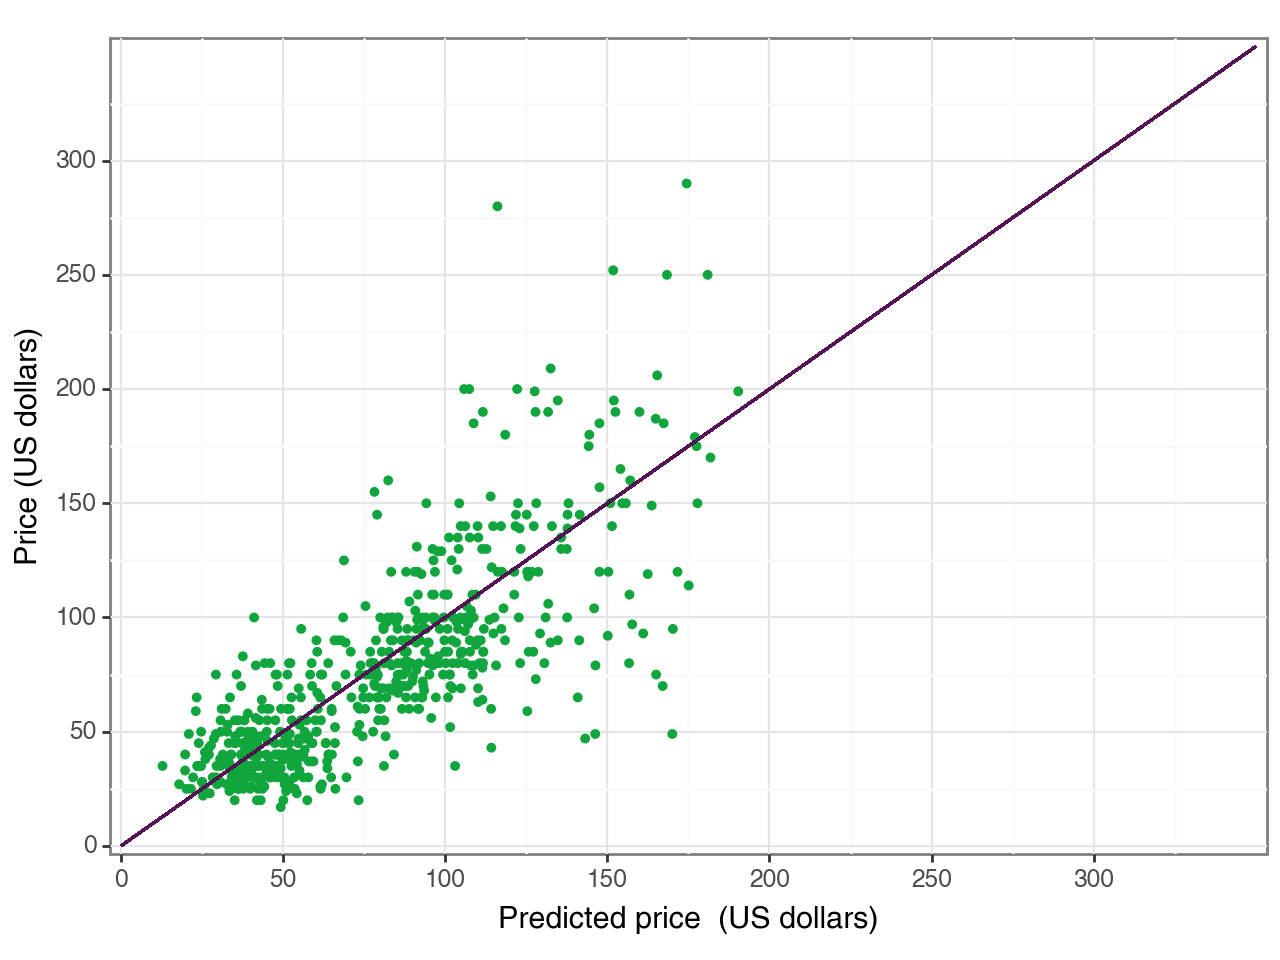

<Figure Size: (640 x 480)>

In [123]:
(
    ggplot(data=data_diagnostic)
    + geom_point(
        aes(y="Ylev", x="mean"),
        color=color[1],
        size=1,
        alpha=0.7,
        show_legend=False,
        na_rm=True,
    )
    + geom_segment(aes(x=0, y=0, xend=350, yend=350), size=0.5, color=color[2])
    + coord_cartesian(xlim=(0, 350), ylim=(0, 350))
    + scale_x_continuous(
        expand=(0.01, 0.01), limits=(0, 350), breaks=seq(0, 350, by=50)
    )
    + scale_y_continuous(
        expand=(0.01, 0.01), limits=(0, 350), breaks=seq(0, 350, by=50)
    )
    + labs(y="Price (US dollars)", x="Predicted price  (US dollars)")
    + theme_bw()
)

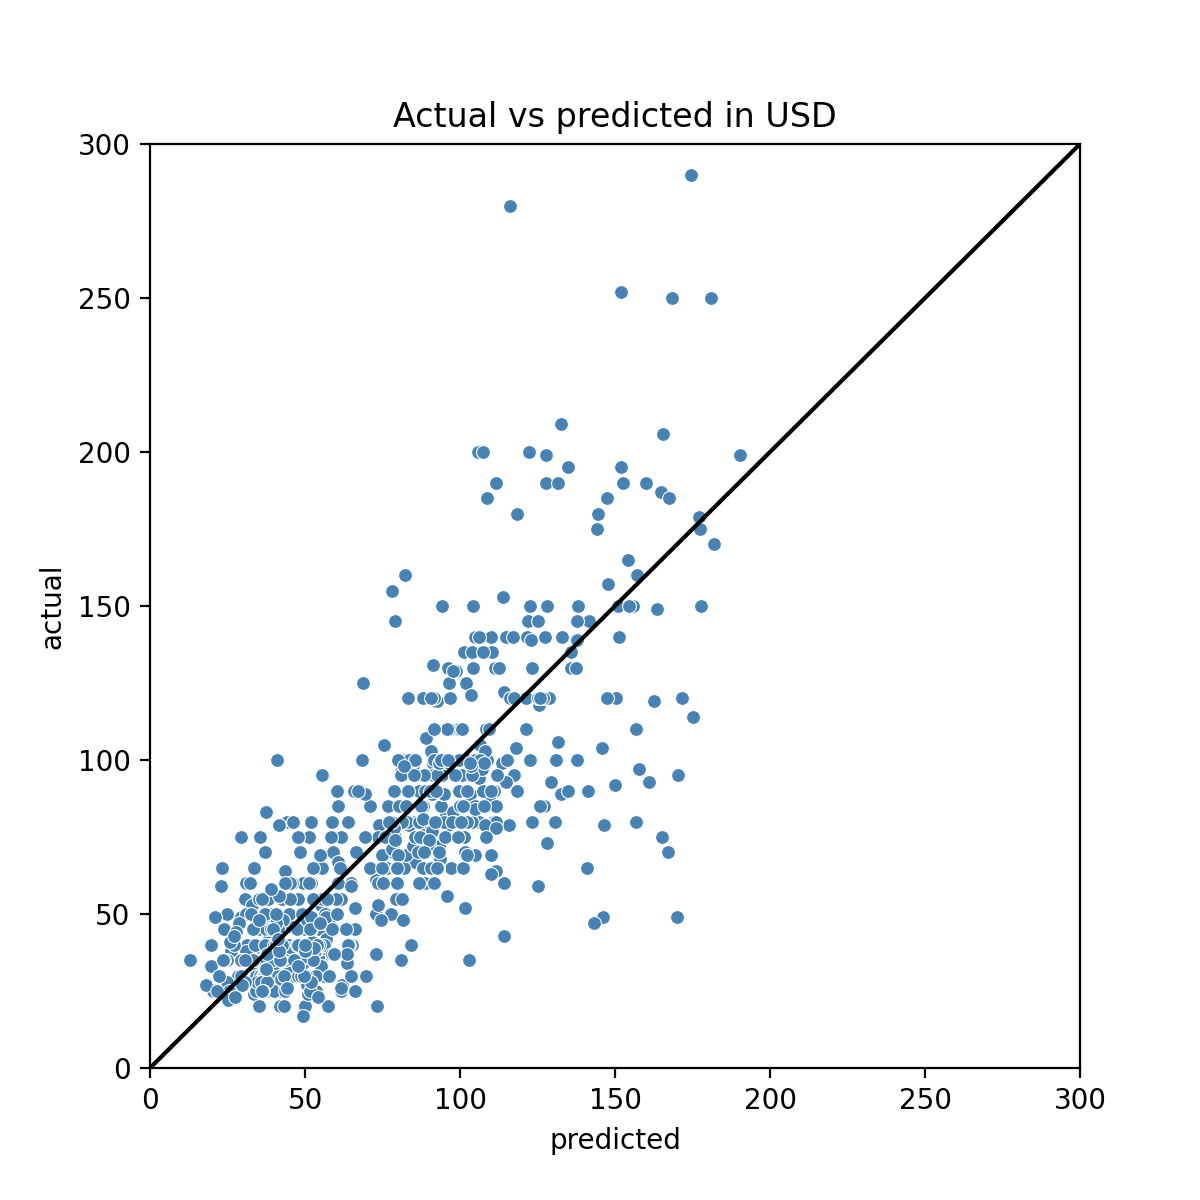

In [124]:
x = np.linspace(0, 300, data_diagnostic.shape[0])

plt.figure(figsize = (6,6))
ax = sns.scatterplot(
    data=data_diagnostic, x="mean", y="Ylev",
    s = 25, color = 'steelblue'
)
plt.plot(x,x, color = 'k')
ax.set_xlim(0,300)
ax.set_ylim(0,300)
ax.set_ylabel('actual')
ax.set_xlabel('predicted')
ax.set_title('Actual vs predicted in USD')
plt.show()

#### Redo predicted values at 80% PI

In [125]:
dt = model7_level.get_prediction(data_holdout).summary_frame(alpha=0.2)
data_extra = pd.concat(
    [
        data_holdout["price"],
        data_holdout["n_accommodates"],
        model7_level.predict(data_holdout),
    ],
    axis=1,
    keys=["price", "n_accommodates", "predicted"],
)
data_extra = data_extra[~data_extra.isna().any(axis=1)].reset_index(drop=True)
dt["n_accommodates"] = data_extra["n_accommodates"]
dt["Ylev"] = data_extra["price"]
dt["elev"] = dt["Ylev"] - dt["mean"]

In [126]:
data_diagnostic = model7_level.get_prediction(data_holdout).summary_frame(alpha=0.2)
df_ = pd.concat(
    [
        data_holdout["price"],
        data_holdout["n_accommodates"],
        model7_level.predict(data_holdout),
    ],
    axis=1,
    keys=["price", "n_accommodates", "predicted"],
)
df_ = df_[~df_.isna().any(axis=1)].reset_index(drop=True)
data_diagnostic["n_accommodates"] = df_["n_accommodates"]
data_diagnostic["Ylev"] = df_["price"]
data_diagnostic["elev"] = data_diagnostic["Ylev"] - data_diagnostic["mean"]

In [127]:
predictionlev_holdout_summary = data_diagnostic.groupby(by=["n_accommodates"]).mean().reset_index()

In [128]:
predictionlev_holdout_summary

,n_accommodates,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper,Ylev,elev
0,1,38.419556,5.288069,31.642623,45.196490,-6.618637,83.457750,34.603448,-3.816108
1,2,58.790371,5.056307,52.310452,65.270289,13.808398,103.772344,57.003058,-1.787313
2,3,85.837793,5.380063,78.942965,92.732622,40.780782,130.894804,88.214286,2.376493
3,4,104.793901,5.488483,97.760126,111.827675,59.727604,149.860198,103.328000,-1.465901
4,5,122.646494,5.397132,115.729791,129.563196,77.634297,167.658690,118.800000,-3.846494
5,6,151.469872,7.301438,142.112703,160.827042,105.918359,197.021386,140.068182,-11.401691
6,7,172.194701,7.953348,162.002076,182.387327,126.573448,217.815954,155.000000,-17.194701


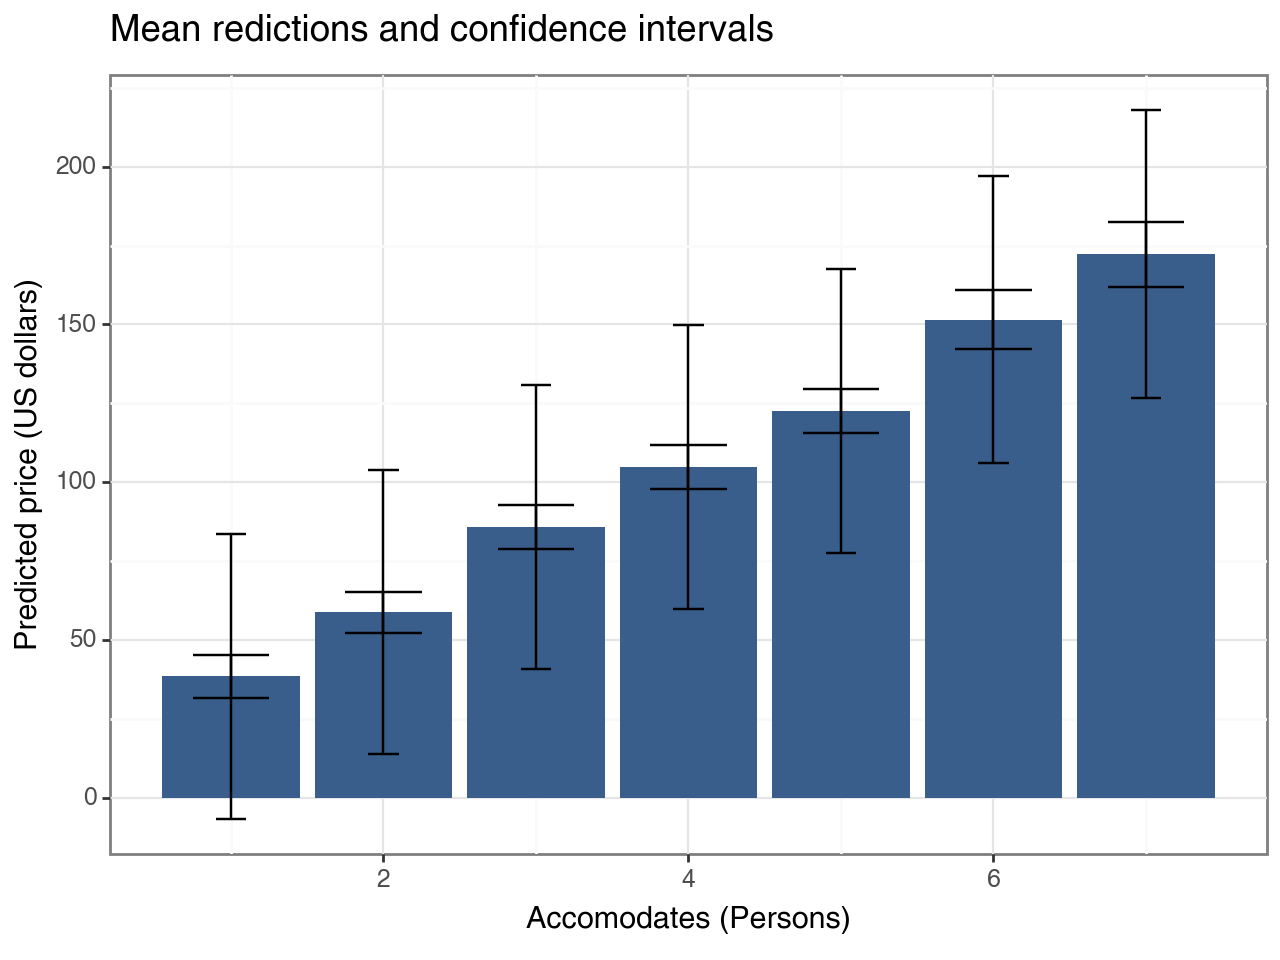

<Figure Size: (640 x 480)>

In [129]:
(
    ggplot(predictionlev_holdout_summary, aes(x="n_accommodates"))
    + geom_bar(aes(y="mean"), stat="identity", fill=color[0], alpha=0.7)
    + geom_errorbar(aes(ymin="obs_ci_lower", ymax="obs_ci_upper"), width=0.2)
    + geom_errorbar(aes(ymin="mean_ci_lower", ymax="mean_ci_upper"), width=0.5)
    + scale_y_continuous(name="Predicted price (US dollars)")
    + scale_x_continuous(name="Accomodates (Persons)")
    + scale_color_manual(values=(color[1], color[1]))
    + labs(title = "Mean redictions and confidence intervals")
    + theme_bw()
    + theme(legend_title=element_blank(), legend_position="none")
    # + theme(legend_title=element_blank(), legend_position="none")
)

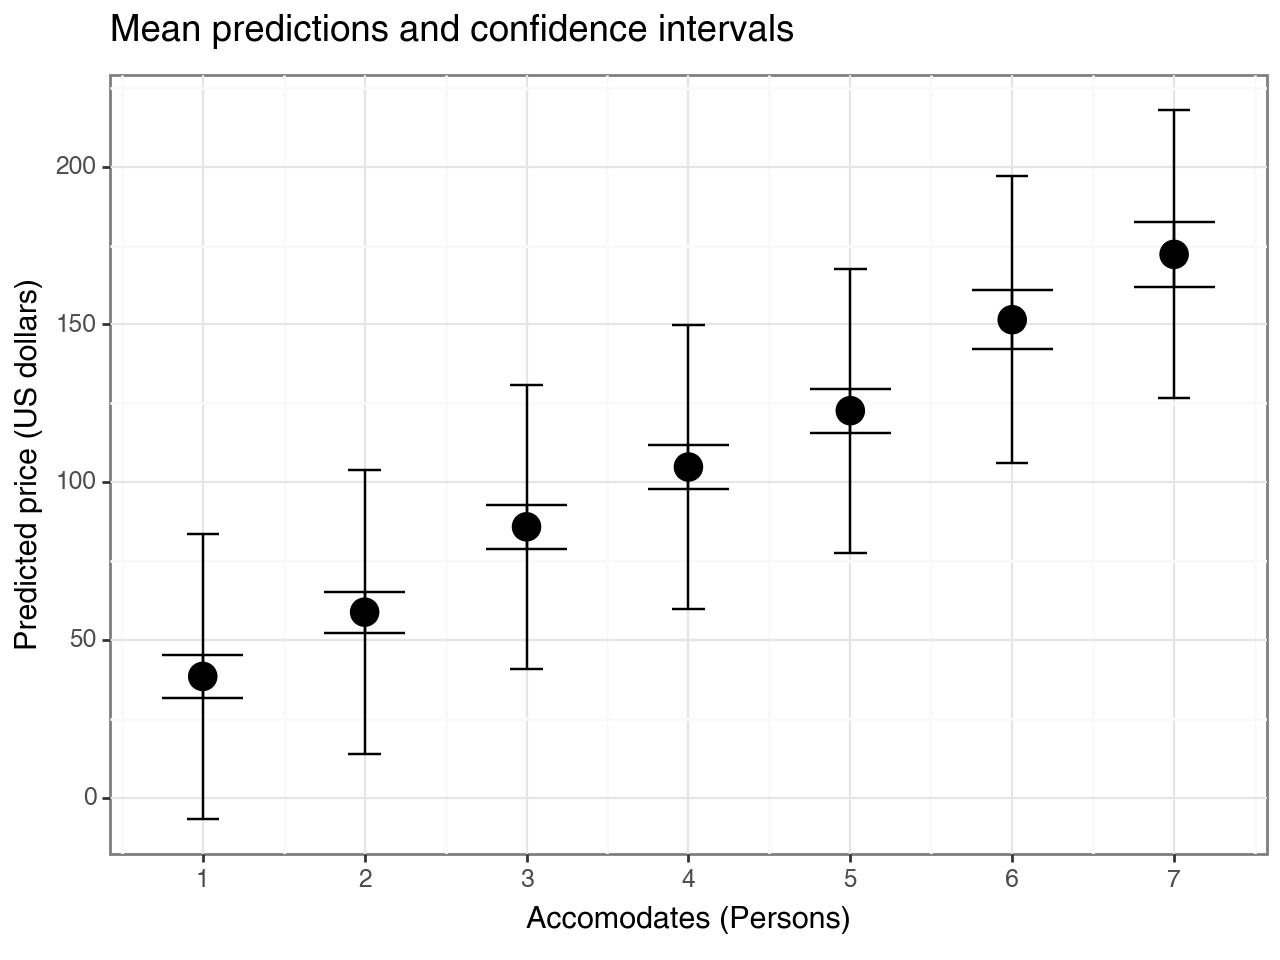

<Figure Size: (640 x 480)>

In [130]:
(
    ggplot(predictionlev_holdout_summary, aes(x="n_accommodates"))
    + geom_point(aes(y="mean"), fill='k',  size = 5)
    + geom_errorbar(aes(ymin="obs_ci_lower", ymax="obs_ci_upper"), width=0.2)
    + geom_errorbar(aes(ymin="mean_ci_lower", ymax="mean_ci_upper"), width=0.5)
    + scale_y_continuous(name="Predicted price (US dollars)")
    + scale_x_continuous(name="Accomodates (Persons)", breaks = [1,2,3,4,5,6, 7])
    + scale_color_manual(values=(color[1], color[1]))
    + labs(title = "Mean predictions and confidence intervals")
    + theme_bw()
    + theme(legend_title=element_blank(), legend_position="none")
)